# Importing libraries and initialising data


In [5]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
import visualkeras 
from PIL import ImageFont
from keras.layers import *

In [6]:
print(tf.__version__)

2.10.0


# Understanding CIFAR 10 dataset
**CIFAR-10 dataset** (Canadian Institute for Advanced Research) is a collection of images that are commonly used to train and benchmark image classification algorithms. It is a subset of 80 million tiny images dataset and consists of 60,000  color images in 10 different classes. There are 50000 training images and 10000 test images. It was collected by Alex Krizhevsky, Vinod Nair, and Geoffrey Hinton. 

<br>

| Label|Description
|-----------|-----------|
|0| airplane|
|1| automobile|
|2| bird|
|3| cat|
|4| deer|
|5| dog|
|6| frog|
|7| horse|
|8| ship|
|9| truck|

# Loading Data Set

In [7]:
#Load data and plot to get a quick understanding
#CIFAR10 classes are: airplane, automobile, bird, cat, deer, dog, frog, horse,
# ship, truck
(x_train, y_train), (x_test, y_test) =tf.keras.datasets.cifar10.load_data()
assert x_train.shape == (50000, 32, 32, 3)
assert x_test.shape == (10000, 32, 32, 3)
assert y_train.shape == (50000, 1)
assert y_test.shape == (10000, 1)


# Feature engineering
>using min max normalization to scale the data  to -1 to 1 to match the output of generator.

In [8]:
from keras.utils import to_categorical

#Generator uses tanh activation so rescale 
#original images to -1 to 1 to match the output of generator.
classes = {
    0: 'Airplane',  1: 'Automobile',
    2: 'Bird',      3: 'Cat',
    4: 'Deer',      5: 'Dog',
    6: 'Frog',      7: 'Horse',
    8: 'Ship',      9: 'Truck' 
}
for i in [x_train, y_train, x_test, y_test]:
    print("Shape:", i.shape)
    print("Data Type:", i.dtype)
    print('Max Value:', i.max())
    print('Min Value:', i.min())
    print("\n")

Shape: (50000, 32, 32, 3)
Data Type: uint8
Max Value: 255
Min Value: 0


Shape: (50000, 1)
Data Type: uint8
Max Value: 9
Min Value: 0


Shape: (10000, 32, 32, 3)
Data Type: uint8
Max Value: 255
Min Value: 0


Shape: (10000, 1)
Data Type: uint8
Max Value: 9
Min Value: 0




# EDA

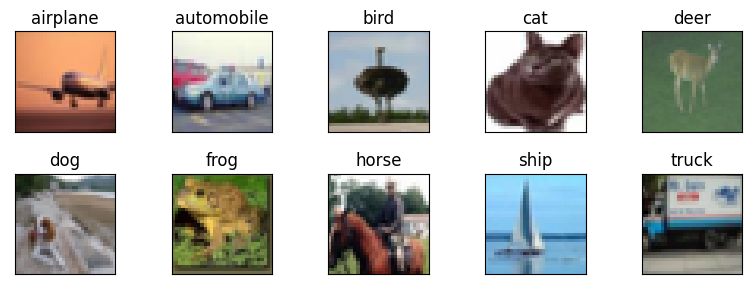

In [9]:

from numpy import zeros
from numpy import ones
from numpy.random import randn
from numpy.random import randint
from keras.datasets.cifar10 import load_data
from keras.optimizers import Adam
from keras.models import Sequential,Model
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.layers import Input
from keras.utils import plot_model, np_utils
from matplotlib import pyplot as plt
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.utils import to_categorical, plot_model
########################################################################



num_classes = len(np.unique(y_train))
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = plt.subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(y_train[:]==i)[0]
    features_idx = x_train[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    img = features_idx[img_num,::]
    ax.set_title(class_names[i])
    plt.imshow(img)
    
plt.tight_layout()


# Trying out GAN for CIFAR-10 
> ## How do Gans Work?

>GANs try to replicate a probability distribution. They should therefore use loss functions that reflect the distance between the distribution of the data generated by the GAN and the distribution of the real data.

## Discriminator built

In [56]:


#############################################################################
#Define generator, discriminator, gan and other helper functions
#Using Sequential method from Keras as it makes the definition of models easy.
#We will use functional way of defining the model for the conditional gan
#but sequential for descriminator and generator as they are straightforward.
#########################################################################

# define the standalone discriminator model
#Given an input image, the Discriminator outputs the likelihood of the image being real.
#Binary classification - true or false (1 or 0). So using sigmoid activation.
def define_discriminator(in_shape=(32,32,3)):
	model = Sequential()
	
	model.add(Conv2D(128, (3,3), strides=(2,2), padding='same', input_shape=in_shape)) #16x16x128
	model.add(LeakyReLU(alpha=0.2))
	
	model.add(Conv2D(128, (3,3), strides=(2,2), padding='same')) #8x8x128
	model.add(LeakyReLU(alpha=0.2))
	
	model.add(Flatten()) #shape of 8192
	model.add(Dropout(0.4))
	model.add(Dense(1, activation='sigmoid')) #shape of 1
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model

test_discr = define_discriminator()
print(test_discr.summary())


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_21 (Conv2D)          (None, 16, 16, 128)       3584      
                                                                 
 leaky_re_lu_33 (LeakyReLU)  (None, 16, 16, 128)       0         
                                                                 
 conv2d_22 (Conv2D)          (None, 8, 8, 128)         147584    
                                                                 
 leaky_re_lu_34 (LeakyReLU)  (None, 8, 8, 128)         0         
                                                                 
 flatten_2 (Flatten)         (None, 8192)              0         
                                                                 
 dropout_2 (Dropout)         (None, 8192)              0         
                                                                 
 dense_9 (Dense)             (None, 1)                

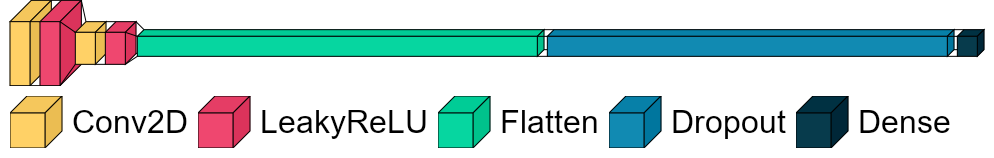

In [57]:

font = ImageFont.truetype("arial.ttf", 32)  # using comic sans is strictly prohibited!
visualkeras.layered_view(define_discriminator(), legend=True, font=font)  # font is optional!


## Generator built

In [58]:

# define the standalone generator model
# #Given input of latent vector, the Generator produces an image.(here: 32x32)
#latent_dim, for example, can be 100, 1D array of size 100 

#Here we are only using Dense and conv2dlayers. But network can be complicated based
#on the application. For example, you can use VGG for super res. GAN.       

def define_generator(latent_dim):    #latent_dim is the dimension of the latent vector (e.g., 100)
	model = Sequential()
	# We will reshape input latent vector into 8x8 image as a starting point. 
    #So n_nodes for the Dense layer can be 128x8x8 so when we reshape the output 
    #it would be 8x8x128 and that can be slowly upscaled to 32x32 image for output.
	n_nodes = 128 * 8 * 8  #8192 nodes
	model.add(Dense(n_nodes, input_dim=latent_dim)) #Dense layer so we can work with 1D latent vector
	model.add(LeakyReLU(alpha=0.2))
	model.add(Reshape((8, 8, 128)))  #8x8x128 dataset from the latent vector. 
	# upsample to 16x16
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')) #16x16x128
	model.add(LeakyReLU(alpha=0.2))
	# upsample to 32x32
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')) #32x32x128
	model.add(LeakyReLU(alpha=0.2))
	# generate
	model.add(Conv2D(3, (8,8), activation='tanh', padding='same')) #32x32x3
	return model  #Model not compiled as it is not directly trained like the discriminator.
                    #Generator is trained via GAN combined model. 

test_gen = define_generator(100)
print(test_gen.summary())



Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_11 (Dense)            (None, 8192)              827392    
                                                                 
 leaky_re_lu_37 (LeakyReLU)  (None, 8192)              0         
                                                                 
 reshape_3 (Reshape)         (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose_9 (Conv2DT  (None, 16, 16, 128)      262272    
 ranspose)                                                       
                                                                 
 leaky_re_lu_38 (LeakyReLU)  (None, 16, 16, 128)       0         
                                                                 
 conv2d_transpose_10 (Conv2D  (None, 32, 32, 128)      262272    
 Transpose)                                           

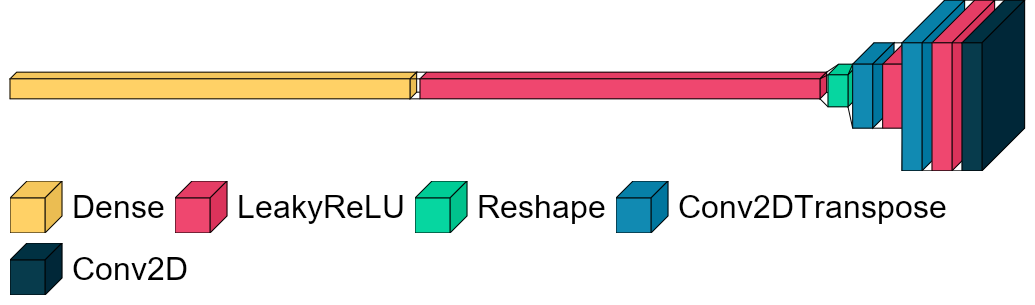

In [59]:

font = ImageFont.truetype("arial.ttf", 32)  # using comic sans is strictly prohibited!
visualkeras.layered_view(define_generator(100), legend=True, font=font)  # font is optional!


## Training the GAN

In [60]:

# define the combined generator and discriminator model, for updating the generator
#Discriminator is trained separately so here only generator will be trained by keeping
#the discriminator constant. 
def define_gan(generator, discriminator):
	discriminator.trainable = False  #Discriminator is trained separately. So set to not trainable.
	# connect generator and discriminator
	model = Sequential()
	model.add(generator)
	model.add(discriminator)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model
	

# load cifar training images
def load_real_samples():
	(x_train, _), (_, _) = load_data()
	# cConvert to float and scale.
	X = x_train.astype('float32')
	# scale from [0,255] to [-1,1]
	X = (X - 127.5) / 127.5  #Generator uses tanh activation so rescale 
                            #original images to -1 to 1 to match the output of generator.
	return X

# pick a batch of random real samples to train the GAN
#In fact, we will train the GAN on a half batch of real images and another 
#half batch of fake images. 
#For each real image we assign a label 1 and for fake we assign label 0. 
def generate_real_samples(dataset, n_samples):
	# choose random images
	ix = randint(0, dataset.shape[0], n_samples)
	# select the random images and assign it to X
	X = dataset[ix]
	# generate class labels and assign to y
	y = ones((n_samples, 1)) ##Label=1 indicating they are real
	return X, y

# generate n_samples number of latent vectors as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

# use the generator to generate n fake examples, with class labels
#Supply the generator, latent_dim and number of samples as input.
#Use the above latent point generator to generate latent points. 
def generate_fake_samples(generator, latent_dim, n_samples):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n_samples)
	# predict using generator to generate fake samples. 
	X = generator.predict(x_input)
	# Class labels will be 0 as these samples are fake. 
	y = zeros((n_samples, 1))  #Label=0 indicating they are fake
	return X, y

def summarize_performance(step, g_model, latent_dim, n_samples=100):
    X, _ = generate_fake_samples(g_model, latent_dim, n_samples)
    X = (X + 1) / 2.0
    for i in range(100):
        plt.subplot(10, 10, 1 + i)
        plt.axis('off')
        plt.imshow(X[i, :, :, 0], cmap='gray_r')

# train the generator and discriminator
#We loop through a number of epochs to train our Discriminator by first selecting
#a random batch of images from our true/real dataset.
#Then, generating a set of images using the generator. 
#Feed both set of images into the Discriminator. 
#Finally, set the loss parameters for both the real and fake images, as well as the combined loss. 

def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=128):
	bat_per_epo = int(dataset.shape[0] / n_batch)
	half_batch = int(n_batch / 2)  #the discriminator model is updated for a half batch of real samples 
                            #and a half batch of fake samples, combined a single batch. 
	# manually enumerate epochs and bacthes. 
	for i in range(n_epochs):
		# enumerate batches over the training set
		for j in range(bat_per_epo):
            
            # Train the discriminator on real and fake images, separately (half batch each)
        #Research showed that separate training is more effective. 
			# get randomly selected 'real' samples
			X_real, y_real = generate_real_samples(dataset, half_batch)
   
			# update discriminator model weights
            ##train_on_batch allows you to update weights based on a collection 
            #of samples you provide
            #Let us just capture loss and ignore accuracy value (2nd output below)
			d_loss_real, _ = d_model.train_on_batch(X_real, y_real) 
			
            # generate 'fake' examples
			X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
			# update discriminator model weights
			d_loss_fake, _ = d_model.train_on_batch(X_fake, y_fake)
            
            #d_loss = 0.5 * np.add(d_loss_real, d_loss_fake) #Average loss if you want to report single..
            
			# prepare points in latent space as input for the generator
			X_gan = generate_latent_points(latent_dim, n_batch)
             
            # The generator wants the discriminator to label the generated samples
			# as valid (ones)
			#This is where the generator is trying to trick discriminator into believing
			#the generated image is true (hence value of 1 for y)			
			y_gan = ones((n_batch, 1))
            
            # Generator is part of combined model where it got directly linked with the discriminator
        # Train the generator with latent_dim as x and 1 as y. 
        # Again, 1 as the output as it is adversarial and if generator did a great
        #job of folling the discriminator then the output would be 1 (true)
			# update the generator via the discriminator's error
			g_loss = gan_model.train_on_batch(X_gan, y_gan)
			
            # Print losses on this batch
			print('Epoch>%d, Batch %d/%d, d1=%.3f, d2=%.3f g=%.3f' %
				(i+1, j+1, bat_per_epo, d_loss_real, d_loss_fake, g_loss))
		#print images for every 10th epoch
		if (i+1) % 10 == 0:
			summarize_performance(i, g_model, d_model, dataset, latent_dim)

	# save the generator model
	g_model.save('./model/cifar_gan_test.h5')


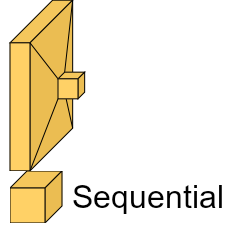

In [61]:
latent_dim = 100
# create the discriminator
discriminator = define_discriminator()
# create the generator
generator = define_generator(latent_dim)
# create the gan
gan_model = define_gan(generator, discriminator)
plot_model(gan_model, show_shapes=True)
font = ImageFont.truetype("arial.ttf", 32)  # using comic sans is strictly prohibited!
visualkeras.layered_view(gan_model, legend=True, font=font)  # font is optional!


In [62]:

###################################################################
#Train the GAN

# size of the latent space

# load image data
dataset = load_real_samples()
# train model
train(generator, discriminator, gan_model, dataset, latent_dim, n_epochs=100)

################################################################################

# Now, let us load the generator model and generate images

from keras.models import load_model
from numpy.random import randn


# Plot generated images 
def show_plot(examples, n):
	for i in range(n * n):
		plt.subplot(n, n, 1 + i)
		plt.axis('off')
		plt.imshow(examples[i, :, :, :])
	plt.show()




KeyboardInterrupt: 

In [ ]:

# load model
model = load_model('./model/cifar_gan_test.h5') #Model trained for 100 epochs
# generate images
latent_points = generate_latent_points(100, 25)  #Latent dim and n_samples
# generate images
X = model.predict(latent_points)
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0

# convert to unsigned integers for viewing
X = (X*255).astype(np.uint8)


1/1 [==============================] - 5s 5s/step


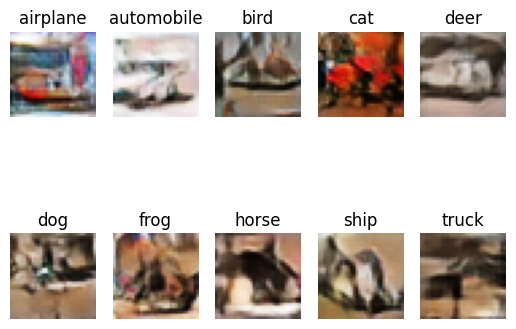

In [ ]:
# plot the result according to classes
classes = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']
for i in range(10):
    plt.subplot(2, 5, 1 + i)
    plt.axis('off')
    plt.imshow(X[i])
    plt.title(classes[i])


In [ ]:
def generator_model():
  model = tf.keras.Sequential([
      tf.keras.layers.Dense(128, input_shape=(100,), activation='relu'),
      tf.keras.layers.Reshape((8, 8, 2)),
      tf.keras.layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', activation='relu'),
      tf.keras.layers.Conv2DTranspose(32, (5, 5), strides=(2, 2), padding='same', activation='relu'),
      tf.keras.layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', activation='tanh')
  ])
  return model

# Define the discriminator model
def discriminator_model():
  model = tf.keras.Sequential([
      tf.keras.layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=(32, 32, 3)),
      tf.keras.layers.LeakyReLU(0.01),
      tf.keras.layers.Dropout(0.3),
      tf.keras.layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'),
      tf.keras.layers.LeakyReLU(0.01),
      tf.keras.layers.Dropout(0.3),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(1, activation='sigmoid')  
  ])
  return model

# Define the GAN model
def gan_model(discriminator, generator):
  model = tf.keras.Sequential()
  model.add(generator)
  model.add(discriminator)
  return model

# Compile the discriminator
discriminator = discriminator_model()
discriminator.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Compile the generator
generator = generator_model()
generator.compile(optimizer='adam', loss='binary_crossentropy')

# Tuning
* Change Latent Space. Update the example to use a larger or smaller latent space and compare the quality of the results and speed of training.
* Batch Normalization. Update the discriminator and/or the generator to make use of batch normalization, recommended for DCGAN models.
* Label Smoothing. Update the example to use one-sided label smoothing when training the discriminator, specifically change the target label of real examples from 1.0 to 0.9 and add random noise, then review the effects on image quality and speed of training.
* Model Configuration. Update the model configuration to use deeper or more shallow discriminator and/or generator models, perhaps experiment with the UpSampling2D layers in the generator.
* Experience Replay 

# Measure Performance
How do you capture the difference between two distributions in GAN loss functions? This question is an area of active research, and many approaches have been proposed. We'll address two common GAN loss functions here, both of which are implemented in TF-GAN:

* minimax loss: The loss function used in the paper that introduced GANs.
* Wasserstein loss: The default loss function for TF-GAN Estimators. First described in a 2017 paper.
* FID scores
  
TF-GAN implements many other loss functions as well.

# Trying out CGAN
>In cGANs, a conditional setting is applied, meaning that both the generator and discriminator are conditioned on some sort of auxiliary information (such as class labels or data) from other modalities. As a result, the ideal model can learn multi-modal mapping from inputs to outputs by being fed with different contextual information.

* By providing additional information, we get two benefits:

* Convergence will be faster. Even the random distribution that the fake images follow will have some pattern.
* You can control the output of the generator at test time by giving the label for the image you want to generate.

In [10]:
# Hyperparameters and Constants
latent_dim = 128
channels = 3
nclasses = 10
img_shape = (32, 32, 3)
discriminator_in_channels = 13

In [11]:
def preprocessing_func(x, y):
    # pixel normalization
    x = x.astype('float32')
    x /= 127.5
    x -= 1
    y = to_categorical(y=y, num_classes=10)

    return x, y

x_train, y_train = preprocessing_func(x_train, y_train)
x_test, y_test = preprocessing_func(x_test, y_test)

In [12]:
# latent noise vector z
from keras.layers import *
z = Input(shape=(128,), name="Latent_Noise_Vector_z")

# conditions y
conditions = Input(shape=(10,), name='Conditions_y')

# Generator network
merged_layer = Concatenate()([z, conditions])

# FC: 2x2x512
generator = Dense(2*2*512, activation='relu')(merged_layer)
generator = BatchNormalization(momentum=0.9)(generator)
generator = LeakyReLU(alpha=0.1)(generator)
generator = Reshape((2, 2, 512))(generator)

base_generator = Sequential([
    # Conv 1: 4x4x256
    Conv2DTranspose(256, kernel_size=4, strides=2, padding='same'),
    BatchNormalization(momentum=0.9),
    LeakyReLU(alpha=0.1),
    # Conv 2: 8x8x128
    Conv2DTranspose(128, kernel_size=4, strides=2, padding='same'),
    BatchNormalization(momentum=0.9),
    LeakyReLU(alpha=0.1),
    # Conv 3: 16x16x64
    Conv2DTranspose(64, kernel_size=4, strides=2, padding='same'),
    BatchNormalization(momentum=0.9),
    LeakyReLU(alpha=0.1),
], name='Base_Generator')
generator = base_generator(generator)

# Conv 4: 32x32x3
generator = Conv2DTranspose(3, kernel_size=4, strides=2, padding='same', activation='tanh', name='Output_Layer')(generator)

generator = Model(inputs=[z, conditions], outputs=generator, name='generator')

generator.summary()

Model: "generator"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Latent_Noise_Vector_z (InputLa  [(None, 128)]       0           []                               
 yer)                                                                                             
                                                                                                  
 Conditions_y (InputLayer)      [(None, 10)]         0           []                               
                                                                                                  
 concatenate_2 (Concatenate)    (None, 138)          0           ['Latent_Noise_Vector_z[0][0]',  
                                                                  'Conditions_y[0][0]']           
                                                                                          

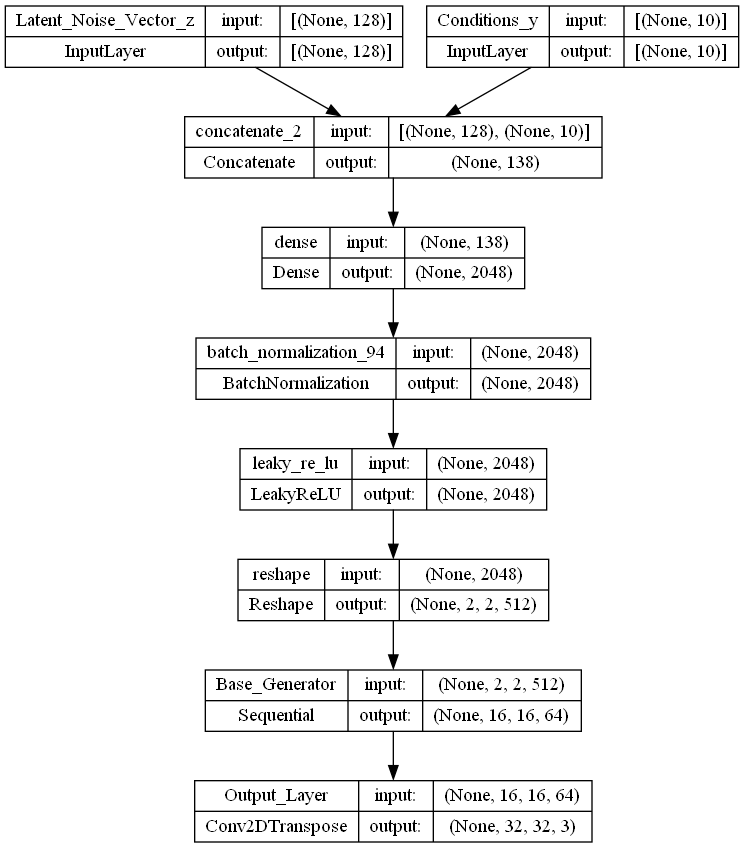

In [13]:
plot_model(generator, show_shapes=True)

In [14]:
# input image
img_input = Input(shape=(x_train[0].shape), name='Image_Input')

# conditions y
conditions = Input(shape=(10,), name='Conditions_y')

base_discriminator = Sequential([
    # 16x16x64
    Conv2D(64, kernel_size=4, strides=2, padding='same'),
    BatchNormalization(momentum=0.9),
    LeakyReLU(alpha=0.1),
    # 8x8x128
    Conv2D(128, kernel_size=4, strides=2, padding='same'),
    BatchNormalization(momentum=0.9),
    LeakyReLU(alpha=0.1),
    # 4x4x256
    Conv2D(256, kernel_size=4, strides=2, padding='same'),
    BatchNormalization(momentum=0.9),
    LeakyReLU(alpha=0.1),
    # 2x2x512
    Conv2D(512, kernel_size=4, strides=2, padding='same'),
    BatchNormalization(momentum=0.9),
    LeakyReLU(alpha=0.1),
], name='Base_Discriminator')
discriminator = base_discriminator(img_input)

# Feature Extraction via GAP: 512
discriminator = GlobalAveragePooling2D()(discriminator)

# Concatenate - combine with conditions y
merged_layer = Concatenate()([discriminator, conditions])
discriminator = Dense(512, activation='relu')(merged_layer)
    
# Output
discriminator = Dense(1, activation='sigmoid', name='Output_Layer')(discriminator)

discriminator = Model(inputs=[img_input, conditions], outputs=discriminator, name='discriminator')

discriminator.summary()

Model: "discriminator"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Image_Input (InputLayer)       [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 Base_Discriminator (Sequential  (None, 2, 2, 512)   2760384     ['Image_Input[0][0]']            
 )                                                                                                
                                                                                                  
 global_average_pooling2d_1 (Gl  (None, 512)         0           ['Base_Discriminator[0][0]']     
 obalAveragePooling2D)                                                                            
                                                                                      

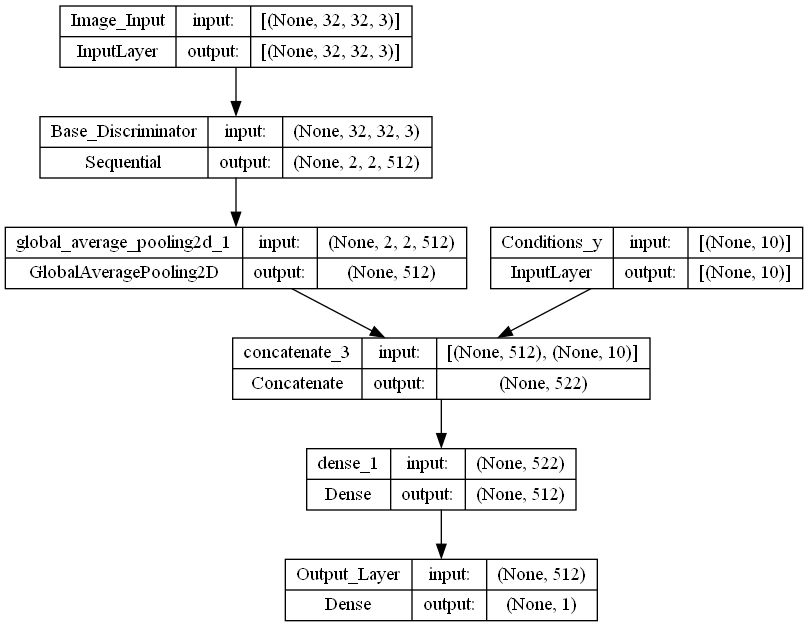

In [15]:
plot_model(discriminator, show_shapes=True)

In [16]:
class ConditionalGAN(tf.keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(ConditionalGAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.gen_loss_tracker = tf.keras.metrics.Mean(name="generator_loss")
        self.disc_loss_tracker = tf.keras.metrics.Mean(name="discriminator_loss")
        self.d_xy_tracker = tf.keras.metrics.Mean(name='Mean D(x|y)')
        self.d_g_zy_tracker = tf.keras.metrics.Mean(name='Mean D(G(z|y))')
        self.kl = tf.keras.metrics.KLDivergence()

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(ConditionalGAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    def train_step(self, data):
        ### TRAINING DISCRIMINATOR ###
        # Unpack the data.
        real_images, condition = data
        
        # Sample for latent noise vector z
        batch_size = tf.shape(real_images)[0]
        latent_noise_vector = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Maps the noise latent vector and labels to generate fake images.
        generated_images = self.generator([latent_noise_vector, condition])

        # Combine with real images
        combined_images = tf.concat([generated_images, real_images], axis=0)
        combined_condition = tf.concat([condition, condition], axis=0)

        # Discrimination
        labels = tf.concat(
            [tf.zeros((batch_size, 1)), tf.ones((batch_size, 1))], axis=0
        )

        # Train the discriminator.
        with tf.GradientTape() as tape:
            first_predictions = self.discriminator([combined_images, combined_condition])
            d_loss = self.loss_fn(labels, first_predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Computing D(x|y)
        d_xy = tf.math.reduce_mean(first_predictions)

        ### TRAINING GENRATOR ###
        latent_noise_vector = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Assemble labels that say "all real images".
        misleading_labels = tf.ones((batch_size, 1))

        with tf.GradientTape() as tape:
            fake_images = self.generator([latent_noise_vector, condition])
            second_predictions = self.discriminator([fake_images, condition])        
            g_loss = self.loss_fn(misleading_labels, second_predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Computing D(G(z|y))
        d_g_zy = tf.math.reduce_mean(second_predictions)

        # Monitor loss and metrics.
        self.gen_loss_tracker.update_state(g_loss)
        self.disc_loss_tracker.update_state(d_loss)
        self.d_xy_tracker.update_state(d_xy)
        self.d_g_zy_tracker.update_state(d_g_zy)
        self.kl.update_state(real_images, fake_images)

        return {
            "d_loss": self.disc_loss_tracker.result(),
            "g_loss": self.gen_loss_tracker.result(),
            "D(x|y)": self.d_xy_tracker.result(),
            "D(G(z|y))": self.d_g_zy_tracker.result(),
            "KL Divergence": self.kl.result(),
        }

In [17]:
import keras 
class GANMonitor(keras.callbacks.Callback):
    # class GANMontor
    # - num_img: number of images generated using matplotlib figure
    # - latent_dim: dimensions of noise latent vector passed into the generator
    # - patience: number of epochs to generate images
    # - vmin: minumum scaling factor, a
    # - vmax: maximum scaling factor, b
    # NOTE: only compatible with the GAN class I've set up
    def __init__(self, num_img=20, latent_dim=128, patience=10, vmin=0, vmax=1):
        self.num_img = num_img
        self.latent_dim = latent_dim
        self.patience = patience
        self.vmin = vmin
        self.vmax = vmax


        # making the latent vec
        self.latent_noise_vector = tf.random.normal(shape=(self.num_img, self.latent_dim))
        self.conditions = to_categorical([0, 1, 2, 3, 4, 5, 6, 7, 8, 9,
                                 0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

    # method to generate images and display them as matplotlib figure
    def generate_plot(self):
        # Generate Images
        generated_images = self.model.generator.predict([self.latent_noise_vector, self.conditions])

        # Normalise Image from [vmin, vmax] to [0, 1]
        generated_images -= self.vmin
        generated_images /= (self.vmax - self.vmin)

        # Generate Matplotlib Figure
        row_size = np.ceil(self.num_img/5)
        fig = plt.figure(figsize=(10, 2*row_size), tight_layout=True)
        for i in range(self.num_img):
            ax = fig.add_subplot(int(row_size), 5, i+1)
            ax.imshow(generated_images[i])
            ax.set_title(classes[i%10])
            ax.axis('off')
        plt.show()

    # method to save generator's weights
    def save_weights(self, epoch=None):
        try:
            if epoch != None:
                name='generator-epoch-{}.h5'.format(epoch)
                print('Generator Checkpoint - {}'.format(name))
                self.model.generator.save_weights(
                    filepath=name,
                    save_format='h5'
                )
        except Exception as e:
            print(e)

    # generate a plot every n epochs
    def on_epoch_begin(self, epoch, logs=None):
        if epoch % self.patience == 0:
            self.generate_plot()
            self.save_weights(epoch)

    # generate a plot after training
    def on_train_end(self, epoch, logs=None):
        self.generate_plot()
        self.save_weights('Full Train')
# List of Callback Functions
callbacks = [
    GANMonitor(num_img=20, latent_dim=128, patience=5, vmin=-1, vmax=1),
]

# Creating a cGAN class
cond_gan = ConditionalGAN(
    discriminator=discriminator, 
    generator=generator, 
    latent_dim=latent_dim
)
# Compiling with Optimizer and Loss Function
cond_gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

1/1 [==============================] - 2s 2s/step


Exception ignored in: <function UniquePtr.__del__ at 0x000001AF1E62A040>
Traceback (most recent call last):
  File "C:\Users\Xavier\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\framework\c_api_util.py", line 71, in __del__
    obj = self._obj
AttributeError: _obj


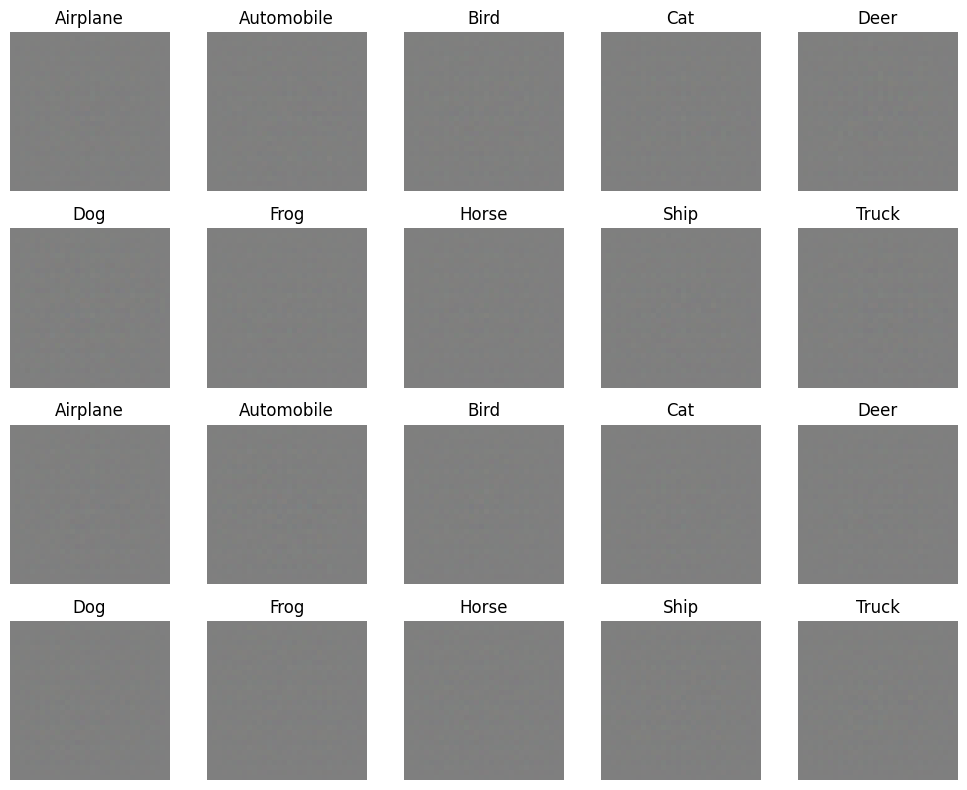

Generator Checkpoint - generator-epoch-0.h5
Epoch 1/100
782/782 [==============================] - 52s 60ms/step - d_loss: 0.3815 - g_loss: 2.9914 - D(x|y): 0.5356 - D(G(z|y)): 0.1305 - KL Divergence: 5.4363
Epoch 2/100
782/782 [==============================] - 46s 58ms/step - d_loss: 0.2134 - g_loss: 3.4859 - D(x|y): 0.4972 - D(G(z|y)): 0.0542 - KL Divergence: 5.6432
Epoch 3/100
782/782 [==============================] - 46s 59ms/step - d_loss: 0.2119 - g_loss: 3.6093 - D(x|y): 0.4960 - D(G(z|y)): 0.0516 - KL Divergence: 5.5203
Epoch 4/100
782/782 [==============================] - 50s 63ms/step - d_loss: 0.2234 - g_loss: 3.3277 - D(x|y): 0.5001 - D(G(z|y)): 0.0568 - KL Divergence: 5.9581
Epoch 5/100
1/1 [==============================] - 0s 66ms/step


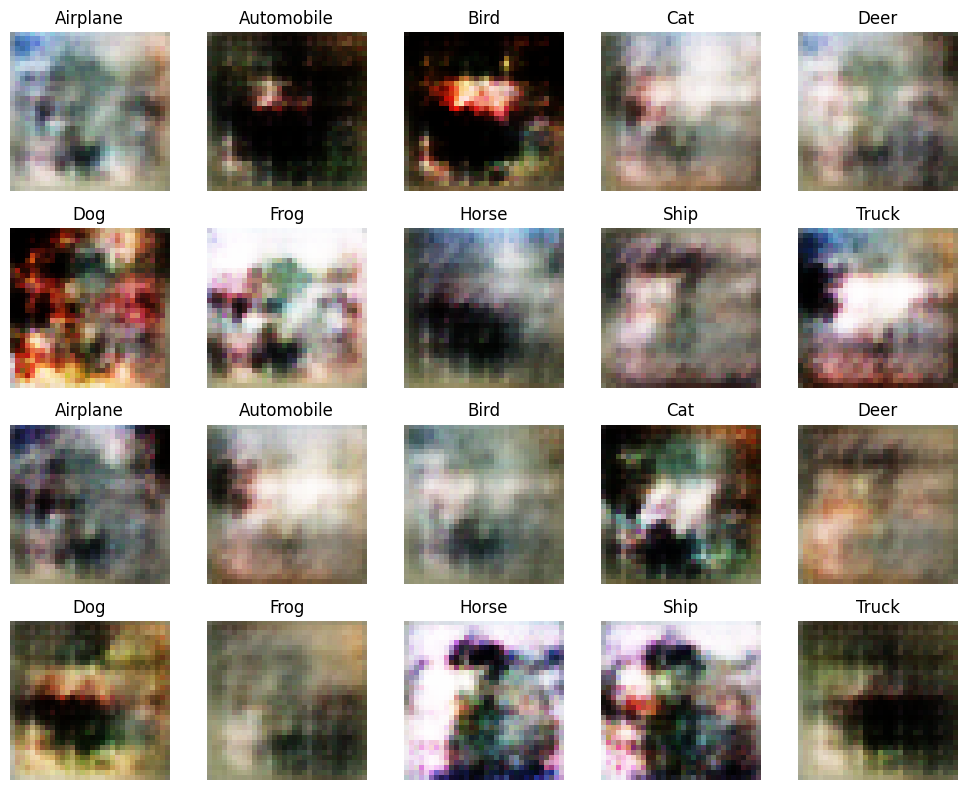

Generator Checkpoint - generator-epoch-5.h5
Epoch 6/100
782/782 [==============================] - 50s 64ms/step - d_loss: 0.2278 - g_loss: 3.3690 - D(x|y): 0.5019 - D(G(z|y)): 0.0581 - KL Divergence: 5.1682
Epoch 7/100
782/782 [==============================] - 48s 62ms/step - d_loss: 0.2575 - g_loss: 3.1197 - D(x|y): 0.5006 - D(G(z|y)): 0.0816 - KL Divergence: 5.1279
Epoch 8/100
782/782 [==============================] - 50s 64ms/step - d_loss: 0.2625 - g_loss: 3.1082 - D(x|y): 0.5002 - D(G(z|y)): 0.0903 - KL Divergence: 4.8825
Epoch 9/100
782/782 [==============================] - 49s 63ms/step - d_loss: 0.2572 - g_loss: 3.0676 - D(x|y): 0.5009 - D(G(z|y)): 0.0972 - KL Divergence: 4.7060
Epoch 10/100
1/1 [==============================] - 0s 37ms/step


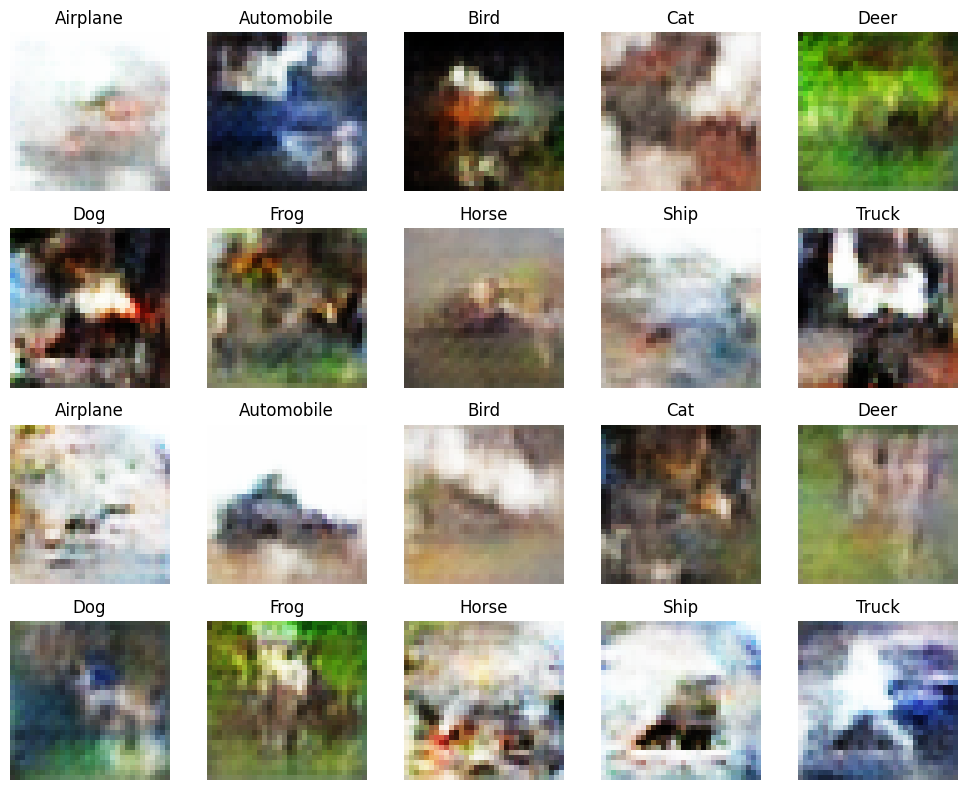

Generator Checkpoint - generator-epoch-10.h5
Epoch 11/100
782/782 [==============================] - 50s 64ms/step - d_loss: 0.2714 - g_loss: 2.8824 - D(x|y): 0.5001 - D(G(z|y)): 0.1211 - KL Divergence: 4.5021
Epoch 12/100
782/782 [==============================] - 50s 64ms/step - d_loss: 0.2738 - g_loss: 2.8536 - D(x|y): 0.4993 - D(G(z|y)): 0.1278 - KL Divergence: 4.5107
Epoch 13/100
782/782 [==============================] - 50s 64ms/step - d_loss: 0.2912 - g_loss: 2.6941 - D(x|y): 0.4992 - D(G(z|y)): 0.1429 - KL Divergence: 4.6895
Epoch 14/100
782/782 [==============================] - 58s 74ms/step - d_loss: 0.2972 - g_loss: 2.6091 - D(x|y): 0.5000 - D(G(z|y)): 0.1565 - KL Divergence: 4.6348
Epoch 15/100
1/1 [==============================] - 0s 129ms/step


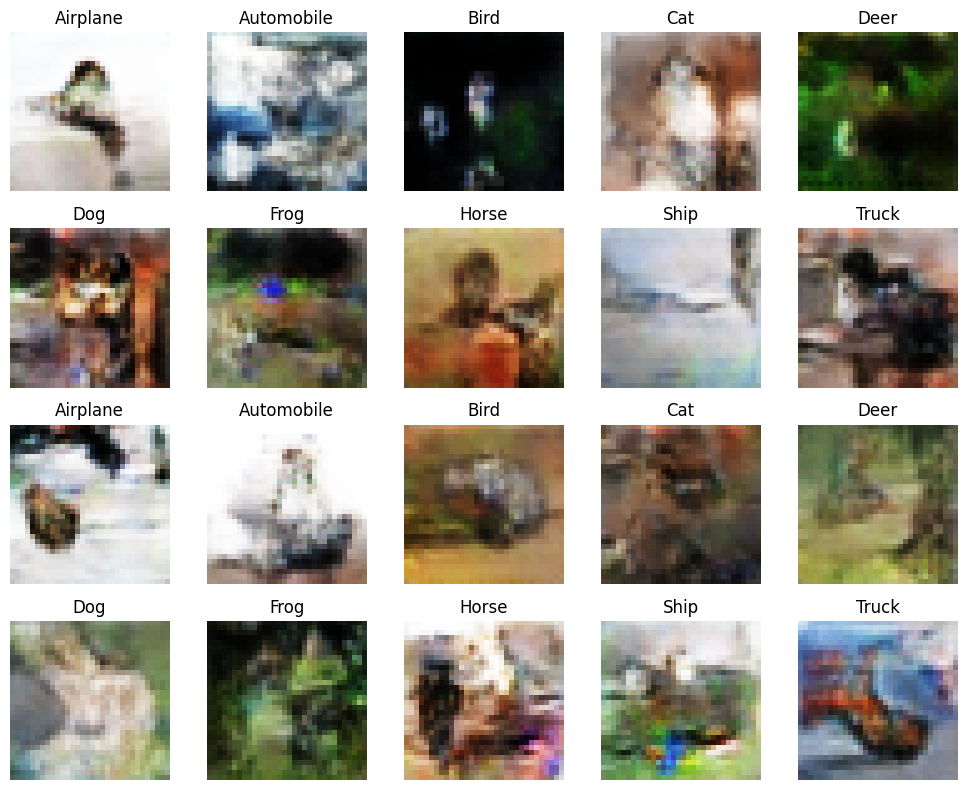

Generator Checkpoint - generator-epoch-15.h5
Epoch 16/100
782/782 [==============================] - 56s 71ms/step - d_loss: 0.2851 - g_loss: 2.7378 - D(x|y): 0.5004 - D(G(z|y)): 0.1538 - KL Divergence: 4.5999
Epoch 17/100
782/782 [==============================] - 54s 69ms/step - d_loss: 0.2689 - g_loss: 2.8535 - D(x|y): 0.5008 - D(G(z|y)): 0.1462 - KL Divergence: 4.6567
Epoch 18/100
782/782 [==============================] - 71s 91ms/step - d_loss: 0.2535 - g_loss: 2.9746 - D(x|y): 0.5005 - D(G(z|y)): 0.1402 - KL Divergence: 4.5906
Epoch 19/100
782/782 [==============================] - 100s 128ms/step - d_loss: 0.2289 - g_loss: 3.2068 - D(x|y): 0.5001 - D(G(z|y)): 0.1268 - KL Divergence: 4.7022
Epoch 20/100
1/1 [==============================] - 0s 97ms/step


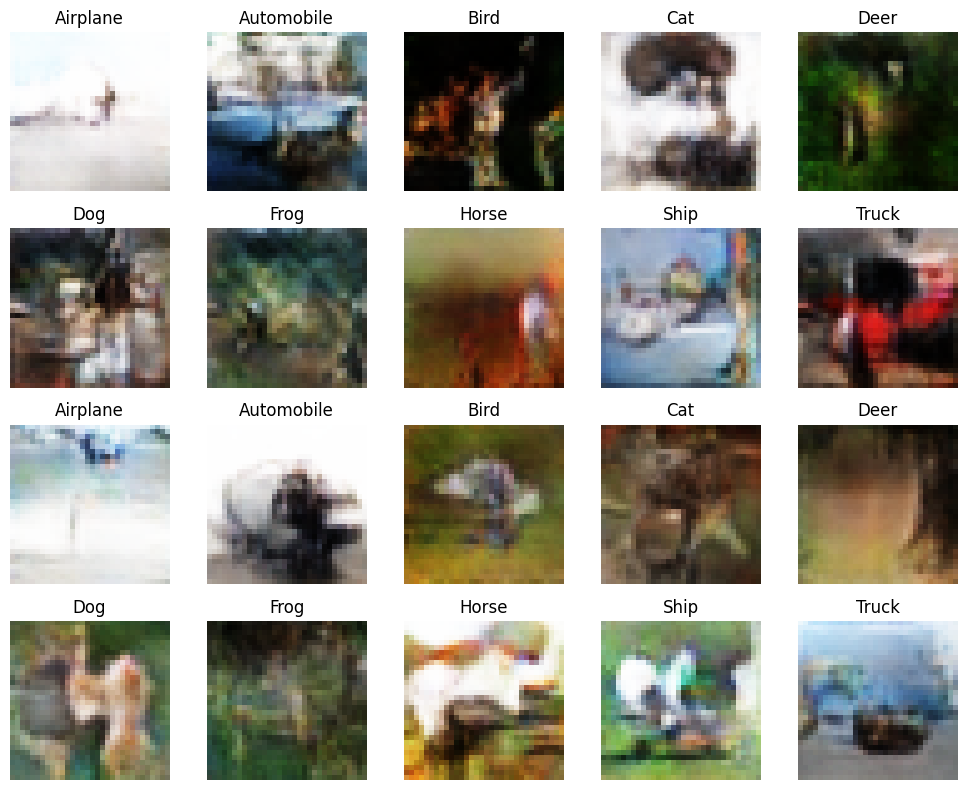

Generator Checkpoint - generator-epoch-20.h5
Epoch 21/100
782/782 [==============================] - 62s 79ms/step - d_loss: 0.2196 - g_loss: 3.4287 - D(x|y): 0.4997 - D(G(z|y)): 0.1204 - KL Divergence: 4.7370
Epoch 22/100
782/782 [==============================] - 65s 83ms/step - d_loss: 0.1889 - g_loss: 3.7373 - D(x|y): 0.5012 - D(G(z|y)): 0.1017 - KL Divergence: 4.7239
Epoch 23/100
782/782 [==============================] - 66s 84ms/step - d_loss: 0.1793 - g_loss: 3.8892 - D(x|y): 0.5000 - D(G(z|y)): 0.0982 - KL Divergence: 4.7524
Epoch 24/100
782/782 [==============================] - 64s 82ms/step - d_loss: 0.1683 - g_loss: 4.0603 - D(x|y): 0.5006 - D(G(z|y)): 0.0925 - KL Divergence: 4.7767
Epoch 25/100
1/1 [==============================] - 0s 161ms/step


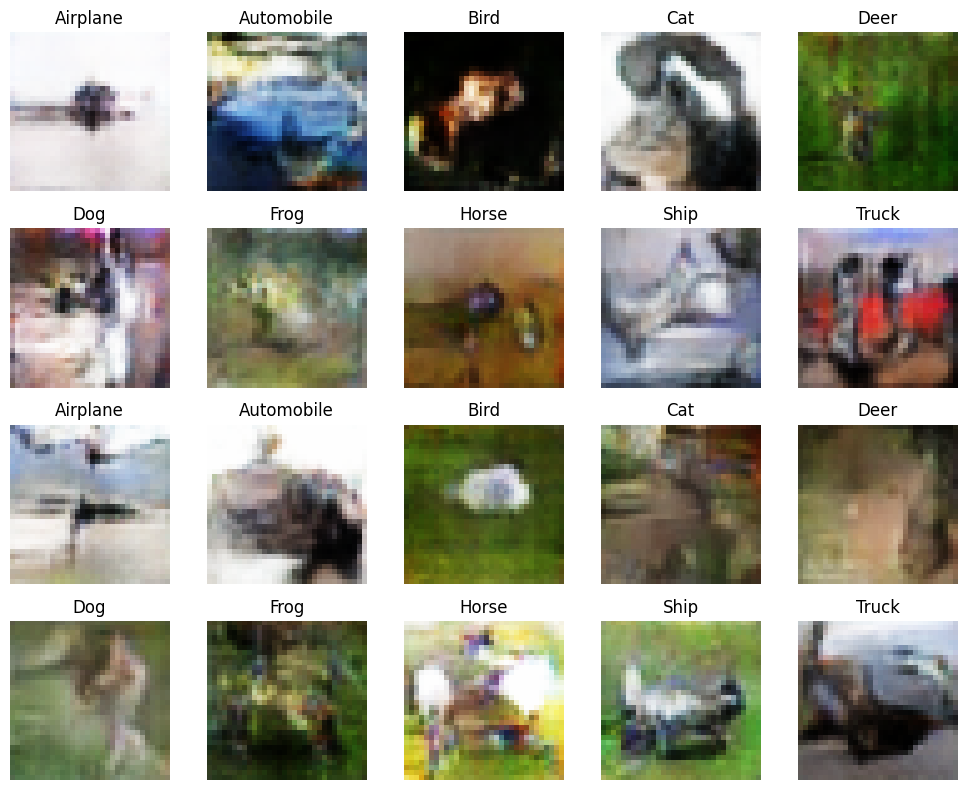

Generator Checkpoint - generator-epoch-25.h5
Epoch 26/100
782/782 [==============================] - 62s 80ms/step - d_loss: 0.1574 - g_loss: 4.4288 - D(x|y): 0.5002 - D(G(z|y)): 0.0853 - KL Divergence: 4.7610
Epoch 27/100
782/782 [==============================] - 63s 81ms/step - d_loss: 0.1476 - g_loss: 4.6467 - D(x|y): 0.5001 - D(G(z|y)): 0.0810 - KL Divergence: 4.7993
Epoch 28/100
782/782 [==============================] - 62s 79ms/step - d_loss: 0.1463 - g_loss: 4.7211 - D(x|y): 0.5000 - D(G(z|y)): 0.0782 - KL Divergence: 4.7435
Epoch 29/100
782/782 [==============================] - 62s 80ms/step - d_loss: 0.1390 - g_loss: 4.8665 - D(x|y): 0.5002 - D(G(z|y)): 0.0774 - KL Divergence: 4.7085
Epoch 30/100
1/1 [==============================] - 0s 103ms/step


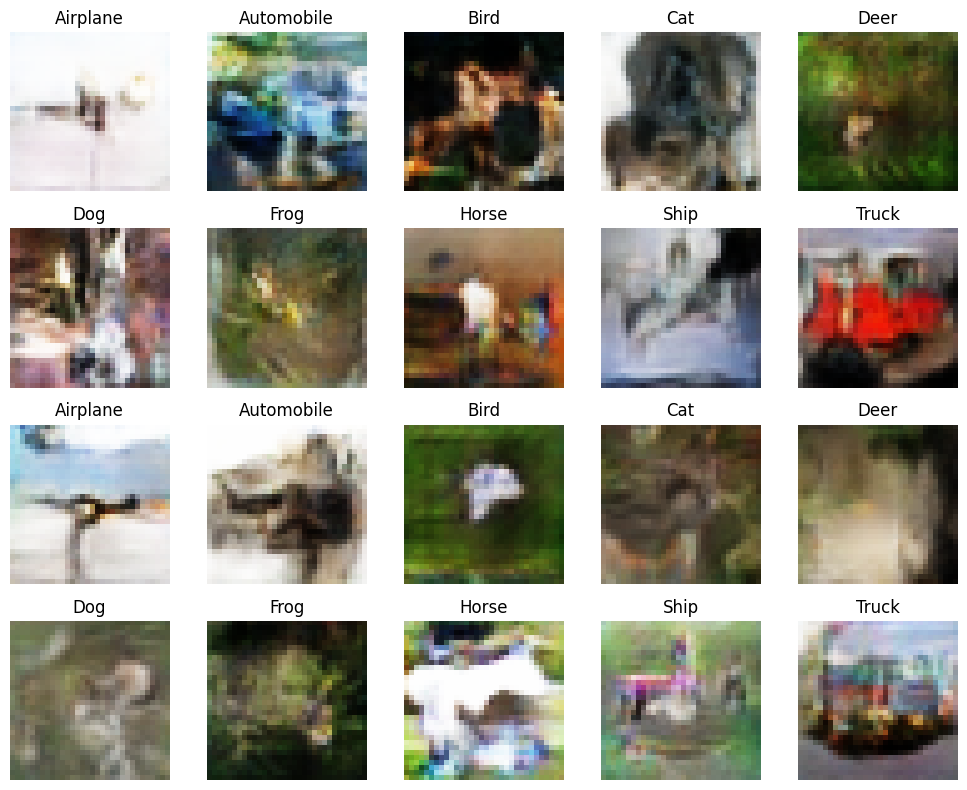

Generator Checkpoint - generator-epoch-30.h5
Epoch 31/100
782/782 [==============================] - 69s 88ms/step - d_loss: 0.1335 - g_loss: 5.1738 - D(x|y): 0.5002 - D(G(z|y)): 0.0727 - KL Divergence: 4.7498
Epoch 32/100
782/782 [==============================] - 82s 105ms/step - d_loss: 0.1324 - g_loss: 5.1501 - D(x|y): 0.4998 - D(G(z|y)): 0.0726 - KL Divergence: 4.7310
Epoch 33/100
782/782 [==============================] - 77s 98ms/step - d_loss: 0.1271 - g_loss: 5.3393 - D(x|y): 0.5007 - D(G(z|y)): 0.0708 - KL Divergence: 4.6791
Epoch 34/100
782/782 [==============================] - 79s 101ms/step - d_loss: 0.1421 - g_loss: 5.3328 - D(x|y): 0.5007 - D(G(z|y)): 0.0761 - KL Divergence: 4.6144
Epoch 35/100
1/1 [==============================] - 0s 60ms/step


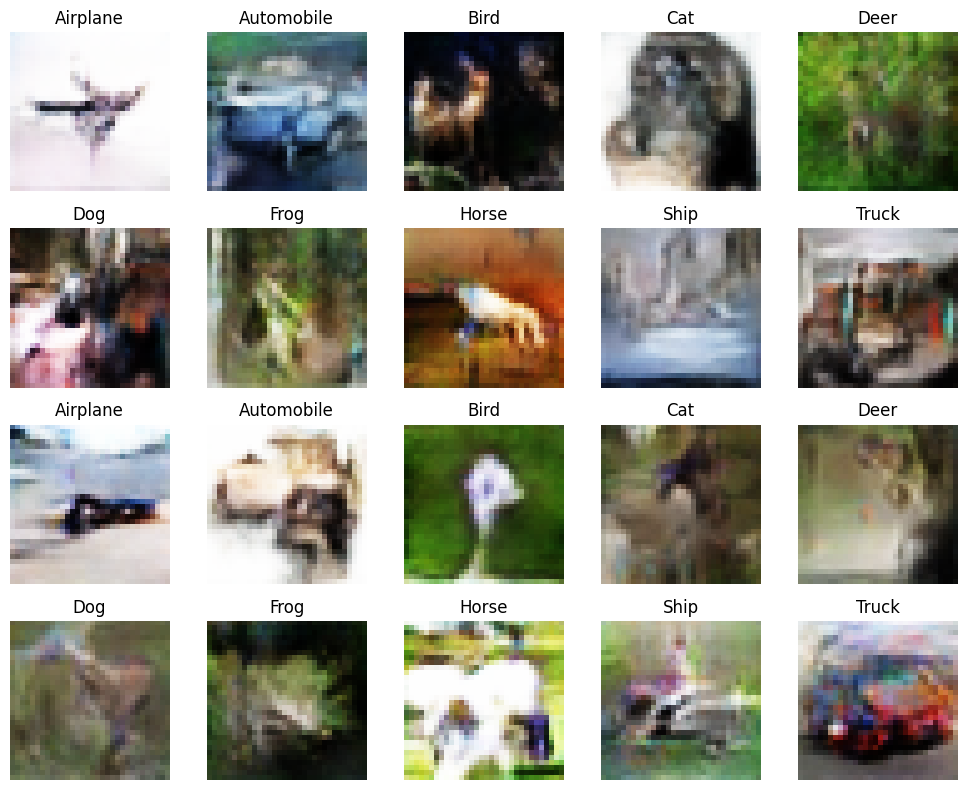

Generator Checkpoint - generator-epoch-35.h5
Epoch 36/100
782/782 [==============================] - 65s 83ms/step - d_loss: 0.1165 - g_loss: 5.6020 - D(x|y): 0.5001 - D(G(z|y)): 0.0651 - KL Divergence: 4.6992
Epoch 37/100
782/782 [==============================] - 62s 80ms/step - d_loss: 0.1188 - g_loss: 5.6924 - D(x|y): 0.5003 - D(G(z|y)): 0.0668 - KL Divergence: 4.6354
Epoch 38/100
782/782 [==============================] - 77s 98ms/step - d_loss: 0.1184 - g_loss: 5.7913 - D(x|y): 0.5000 - D(G(z|y)): 0.0652 - KL Divergence: 4.7061
Epoch 39/100
782/782 [==============================] - 66s 85ms/step - d_loss: 0.1110 - g_loss: 5.8929 - D(x|y): 0.5002 - D(G(z|y)): 0.0635 - KL Divergence: 4.6192
Epoch 40/100
1/1 [==============================] - 0s 65ms/step


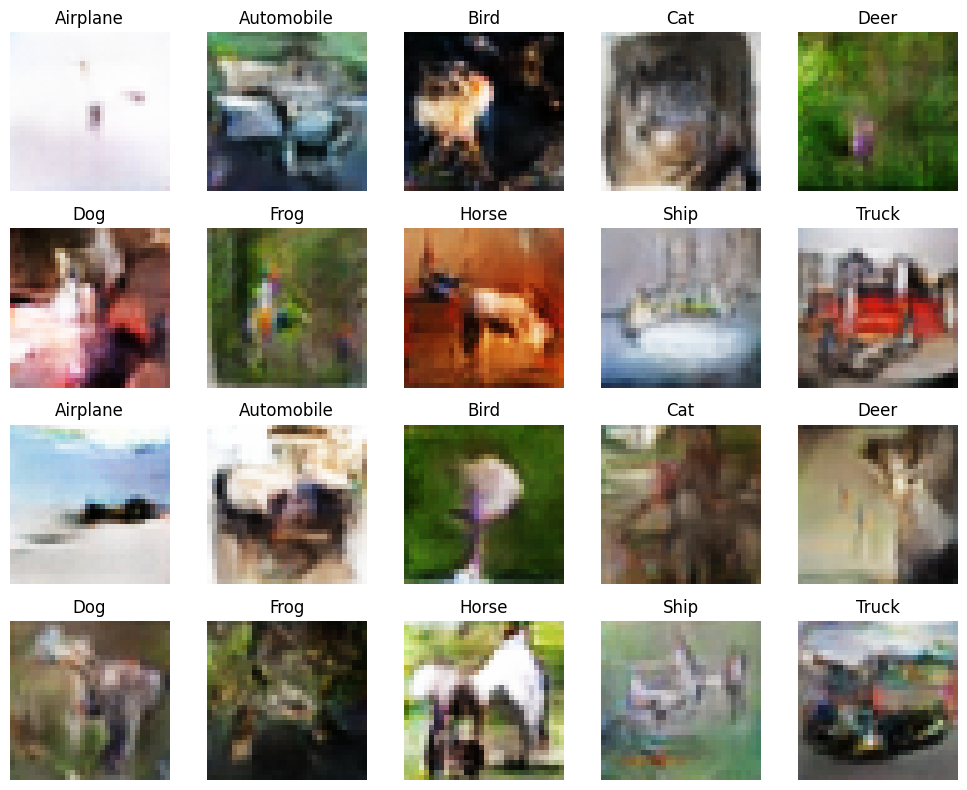

Generator Checkpoint - generator-epoch-40.h5
Epoch 41/100
782/782 [==============================] - 66s 83ms/step - d_loss: 0.1103 - g_loss: 6.0329 - D(x|y): 0.5003 - D(G(z|y)): 0.0595 - KL Divergence: 4.5472
Epoch 42/100
782/782 [==============================] - 68s 87ms/step - d_loss: 0.1035 - g_loss: 6.2000 - D(x|y): 0.5002 - D(G(z|y)): 0.0579 - KL Divergence: 4.5832
Epoch 43/100
782/782 [==============================] - 74s 95ms/step - d_loss: 0.1133 - g_loss: 6.1984 - D(x|y): 0.4999 - D(G(z|y)): 0.0611 - KL Divergence: 4.5578
Epoch 44/100
782/782 [==============================] - 63s 80ms/step - d_loss: 0.1064 - g_loss: 6.3357 - D(x|y): 0.5000 - D(G(z|y)): 0.0582 - KL Divergence: 4.5620
Epoch 45/100
1/1 [==============================] - 0s 81ms/step


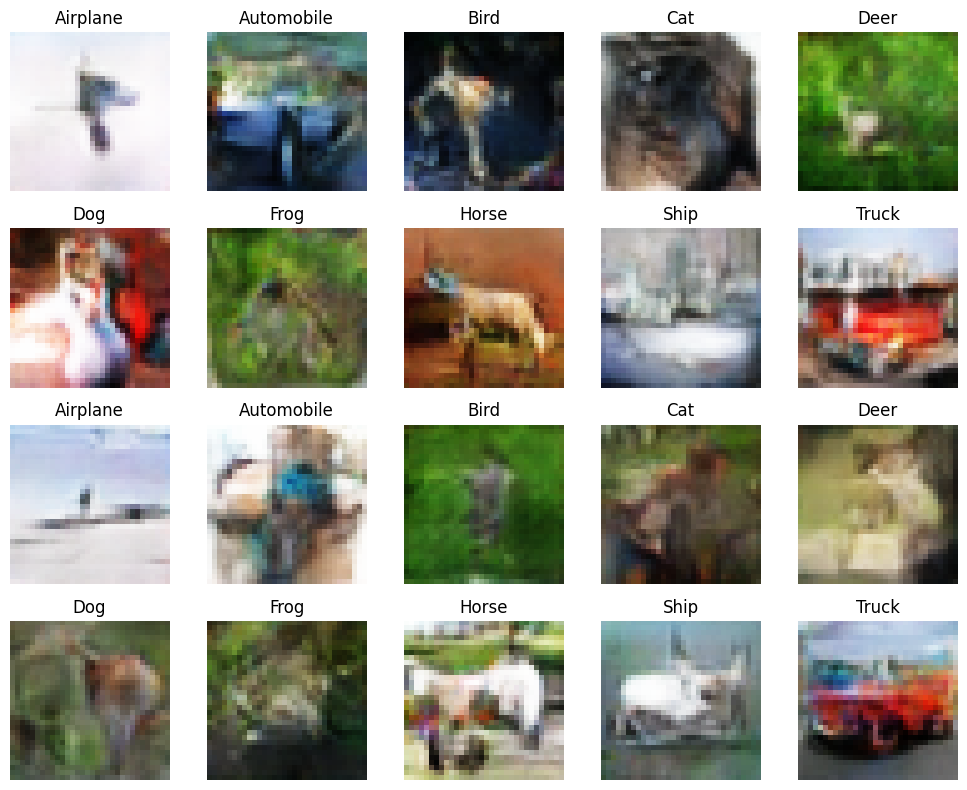

Generator Checkpoint - generator-epoch-45.h5
Epoch 46/100
782/782 [==============================] - 62s 79ms/step - d_loss: 0.1007 - g_loss: 6.4731 - D(x|y): 0.4998 - D(G(z|y)): 0.0557 - KL Divergence: 4.5387
Epoch 47/100
782/782 [==============================] - 69s 88ms/step - d_loss: 0.1015 - g_loss: 6.5515 - D(x|y): 0.4997 - D(G(z|y)): 0.0570 - KL Divergence: 4.5588
Epoch 48/100
782/782 [==============================] - 59s 76ms/step - d_loss: 0.1022 - g_loss: 6.5929 - D(x|y): 0.4998 - D(G(z|y)): 0.0554 - KL Divergence: 4.4310
Epoch 49/100
782/782 [==============================] - 61s 78ms/step - d_loss: 0.1044 - g_loss: 6.5890 - D(x|y): 0.5005 - D(G(z|y)): 0.0536 - KL Divergence: 4.4891
Epoch 50/100
1/1 [==============================] - 0s 332ms/step


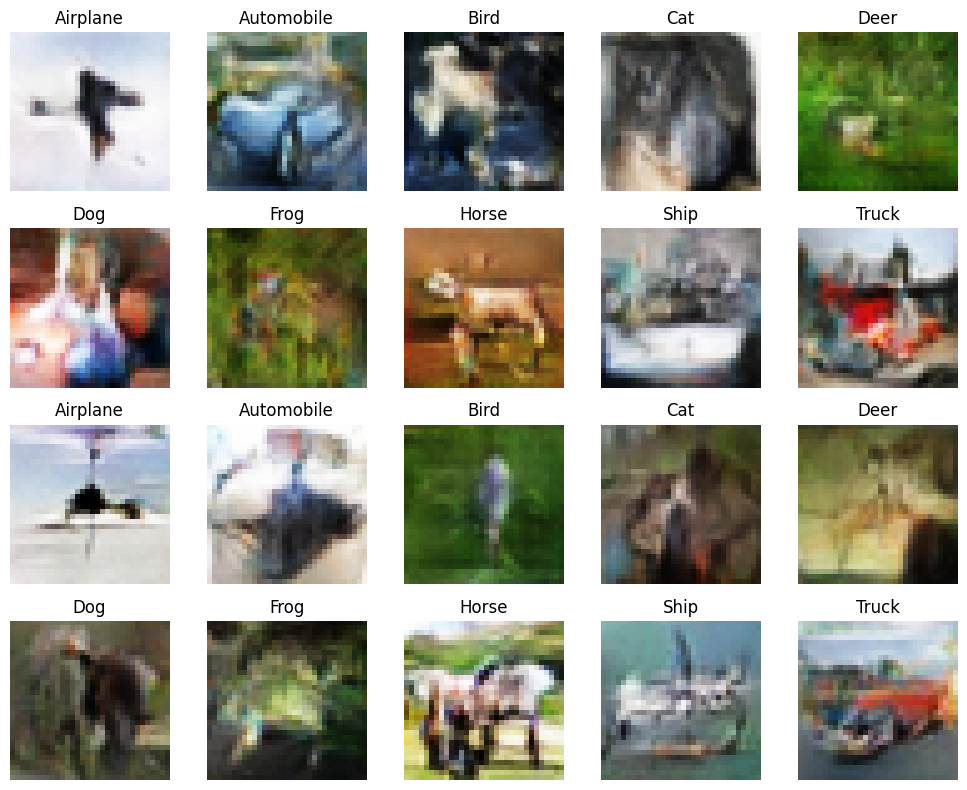

Generator Checkpoint - generator-epoch-50.h5
Epoch 51/100
782/782 [==============================] - 71s 91ms/step - d_loss: 0.1040 - g_loss: 6.6830 - D(x|y): 0.5007 - D(G(z|y)): 0.0539 - KL Divergence: 4.6050
Epoch 52/100
782/782 [==============================] - 59s 75ms/step - d_loss: 0.1008 - g_loss: 6.7902 - D(x|y): 0.4997 - D(G(z|y)): 0.0542 - KL Divergence: 4.6309
Epoch 53/100
782/782 [==============================] - 72s 91ms/step - d_loss: 0.0934 - g_loss: 6.8343 - D(x|y): 0.5002 - D(G(z|y)): 0.0520 - KL Divergence: 4.5767
Epoch 54/100
782/782 [==============================] - 79s 101ms/step - d_loss: 0.0935 - g_loss: 6.9205 - D(x|y): 0.5002 - D(G(z|y)): 0.0512 - KL Divergence: 4.4976
Epoch 55/100
1/1 [==============================] - 0s 67ms/step


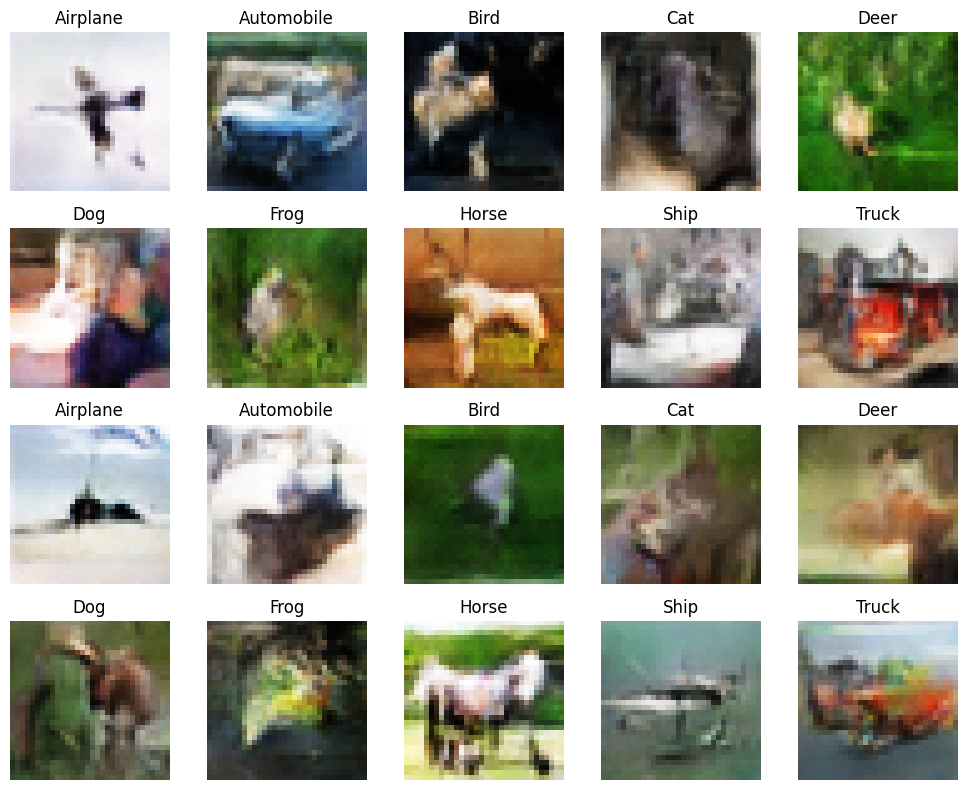

Generator Checkpoint - generator-epoch-55.h5
Epoch 56/100
782/782 [==============================] - 58s 75ms/step - d_loss: 0.0926 - g_loss: 7.0916 - D(x|y): 0.4999 - D(G(z|y)): 0.0509 - KL Divergence: 4.6204
Epoch 57/100
782/782 [==============================] - 59s 75ms/step - d_loss: 0.0937 - g_loss: 7.1093 - D(x|y): 0.4999 - D(G(z|y)): 0.0525 - KL Divergence: 4.5120
Epoch 58/100
782/782 [==============================] - 58s 74ms/step - d_loss: 0.0884 - g_loss: 7.2703 - D(x|y): 0.5004 - D(G(z|y)): 0.0486 - KL Divergence: 4.5629
Epoch 59/100
782/782 [==============================] - 59s 75ms/step - d_loss: 0.0916 - g_loss: 7.3103 - D(x|y): 0.4998 - D(G(z|y)): 0.0485 - KL Divergence: 4.6392
Epoch 60/100
1/1 [==============================] - 0s 59ms/step


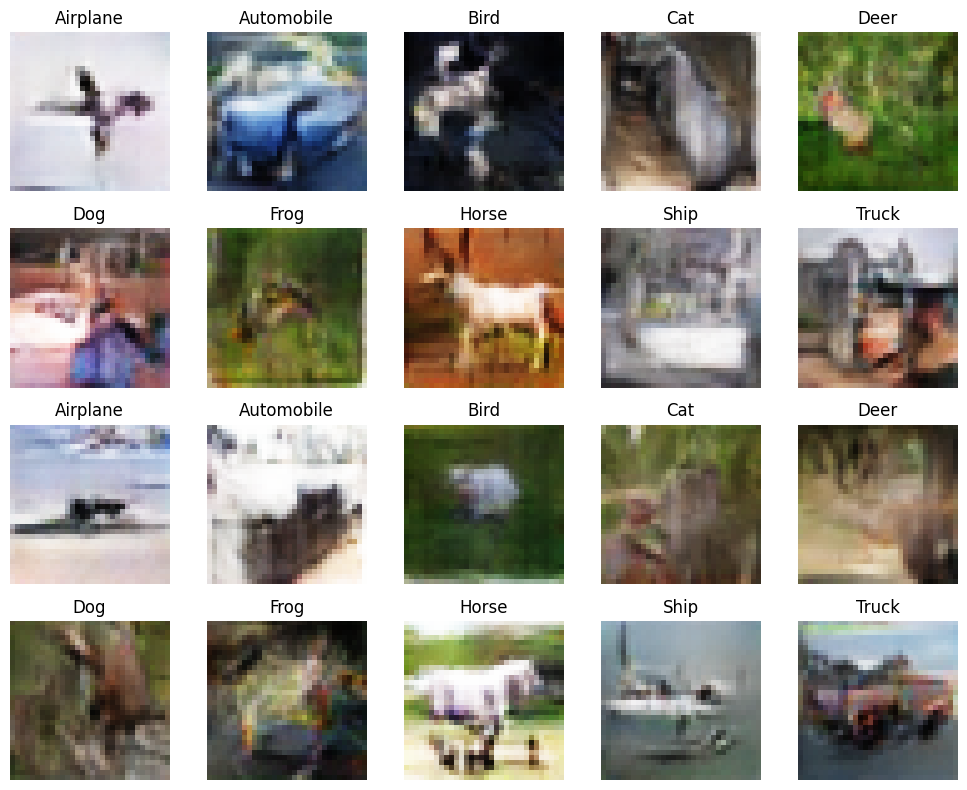

Generator Checkpoint - generator-epoch-60.h5
Epoch 61/100
782/782 [==============================] - 58s 74ms/step - d_loss: 0.0838 - g_loss: 7.4537 - D(x|y): 0.5004 - D(G(z|y)): 0.0469 - KL Divergence: 4.6907
Epoch 62/100
782/782 [==============================] - 69s 88ms/step - d_loss: 0.0849 - g_loss: 7.4622 - D(x|y): 0.5001 - D(G(z|y)): 0.0462 - KL Divergence: 4.7012
Epoch 63/100
782/782 [==============================] - 61s 78ms/step - d_loss: 0.1364 - g_loss: 6.8708 - D(x|y): 0.4997 - D(G(z|y)): 0.0674 - KL Divergence: 4.6993
Epoch 64/100
782/782 [==============================] - 60s 77ms/step - d_loss: 0.0651 - g_loss: 7.4551 - D(x|y): 0.5002 - D(G(z|y)): 0.0378 - KL Divergence: 5.0075
Epoch 65/100
1/1 [==============================] - 0s 70ms/step


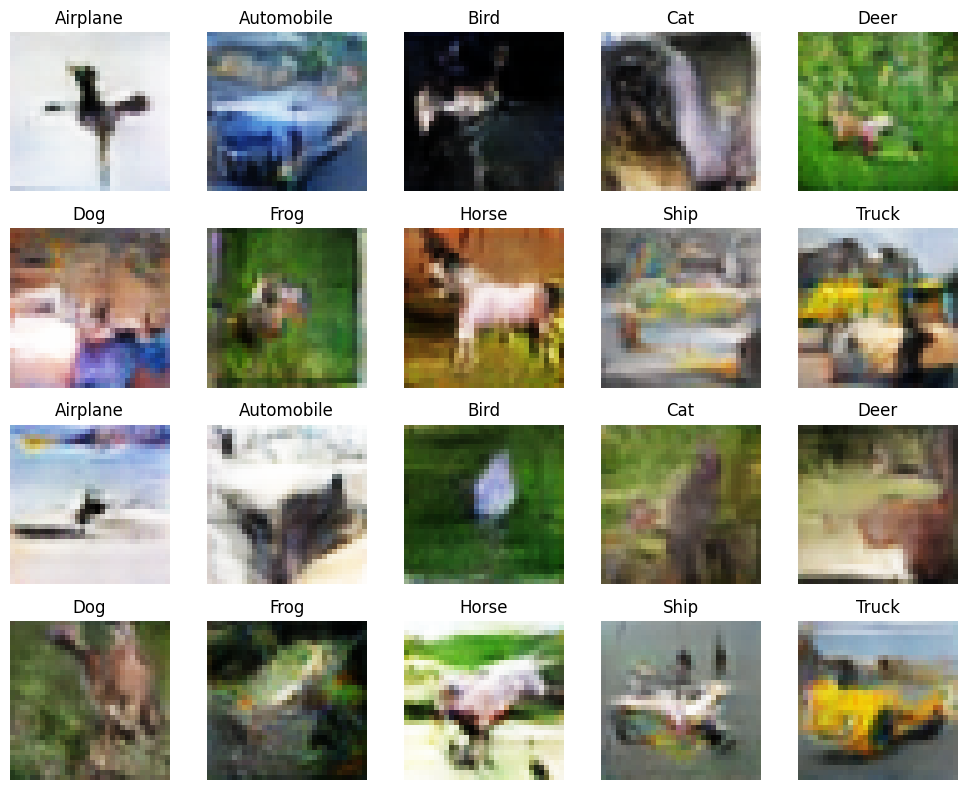

Generator Checkpoint - generator-epoch-65.h5
Epoch 66/100
782/782 [==============================] - 61s 79ms/step - d_loss: 0.0820 - g_loss: 7.4764 - D(x|y): 0.4996 - D(G(z|y)): 0.0432 - KL Divergence: 4.7096
Epoch 67/100
782/782 [==============================] - 61s 78ms/step - d_loss: 0.0878 - g_loss: 7.5343 - D(x|y): 0.4998 - D(G(z|y)): 0.0445 - KL Divergence: 4.5922
Epoch 68/100
782/782 [==============================] - 66s 84ms/step - d_loss: 0.0821 - g_loss: 7.6104 - D(x|y): 0.4998 - D(G(z|y)): 0.0435 - KL Divergence: 4.6351
Epoch 69/100
782/782 [==============================] - 75s 96ms/step - d_loss: 0.0770 - g_loss: 7.8285 - D(x|y): 0.4999 - D(G(z|y)): 0.0424 - KL Divergence: 4.6829
Epoch 70/100
1/1 [==============================] - 0s 73ms/step


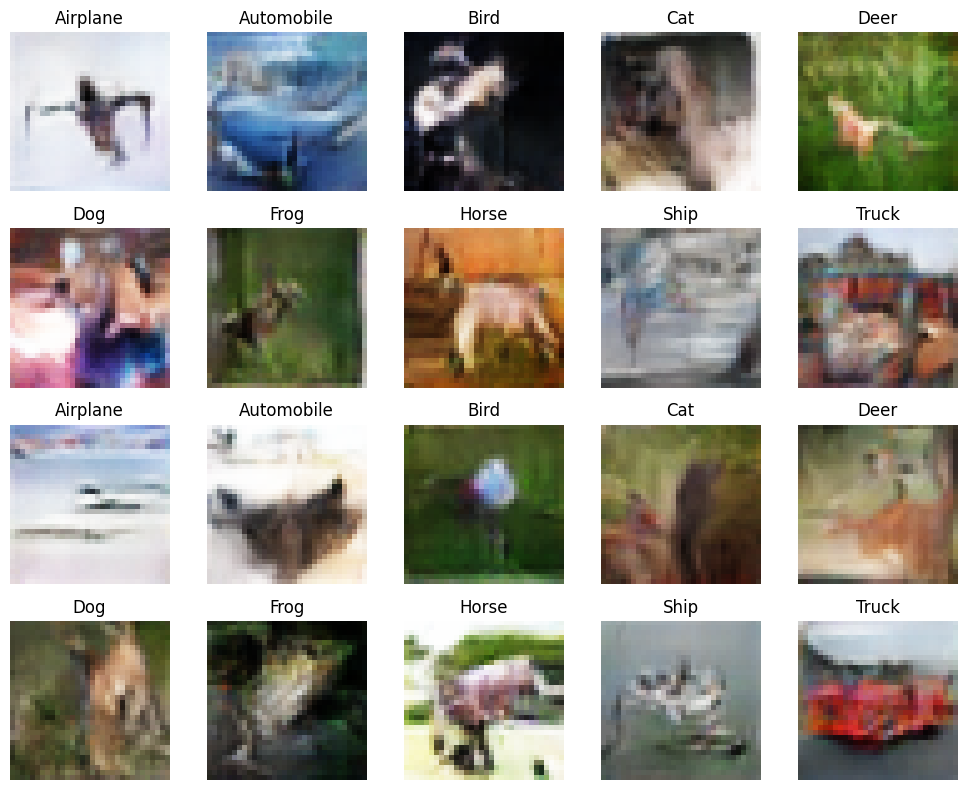

Generator Checkpoint - generator-epoch-70.h5
Epoch 71/100
782/782 [==============================] - 74s 94ms/step - d_loss: 0.0849 - g_loss: 7.6652 - D(x|y): 0.5000 - D(G(z|y)): 0.0434 - KL Divergence: 4.6292
Epoch 72/100
782/782 [==============================] - 66s 84ms/step - d_loss: 0.0781 - g_loss: 7.8498 - D(x|y): 0.4999 - D(G(z|y)): 0.0408 - KL Divergence: 4.5978
Epoch 73/100
782/782 [==============================] - 63s 80ms/step - d_loss: 0.0737 - g_loss: 8.0536 - D(x|y): 0.4998 - D(G(z|y)): 0.0412 - KL Divergence: 4.4309
Epoch 74/100
782/782 [==============================] - 61s 78ms/step - d_loss: 0.0712 - g_loss: 8.1203 - D(x|y): 0.5002 - D(G(z|y)): 0.0394 - KL Divergence: 4.4360
Epoch 75/100
1/1 [==============================] - 0s 58ms/step


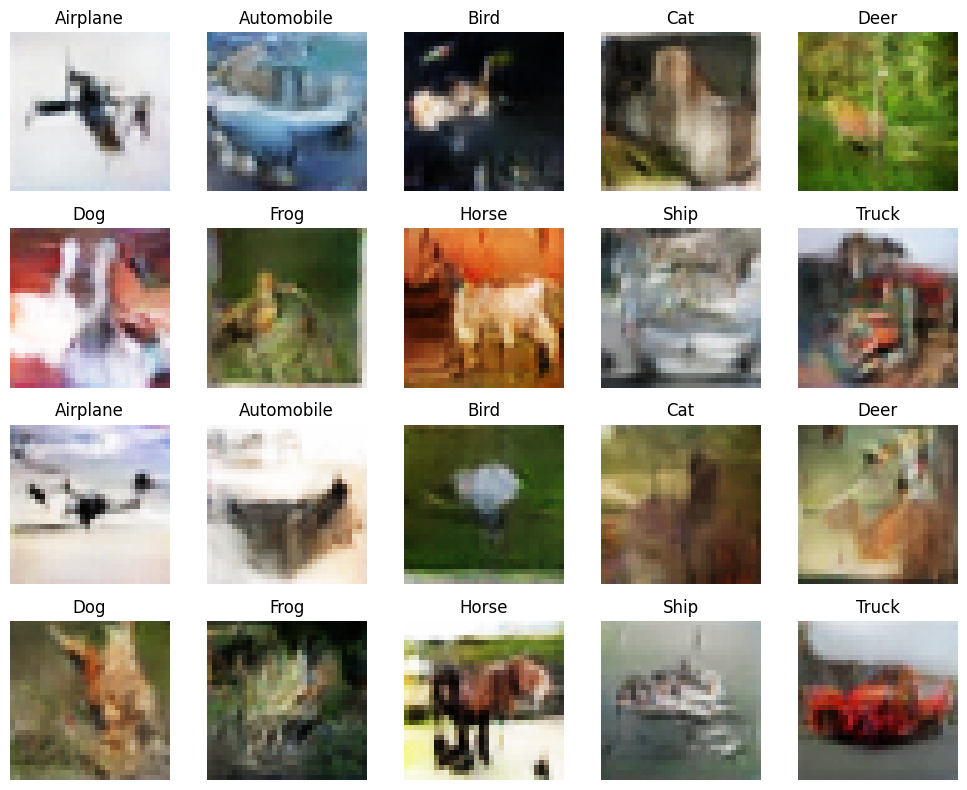

Generator Checkpoint - generator-epoch-75.h5
Epoch 76/100
782/782 [==============================] - 51s 65ms/step - d_loss: 0.0763 - g_loss: 8.0898 - D(x|y): 0.4997 - D(G(z|y)): 0.0406 - KL Divergence: 4.5264
Epoch 77/100
782/782 [==============================] - 52s 67ms/step - d_loss: 0.0752 - g_loss: 8.2292 - D(x|y): 0.5001 - D(G(z|y)): 0.0403 - KL Divergence: 4.3751
Epoch 78/100
782/782 [==============================] - 53s 67ms/step - d_loss: 0.0721 - g_loss: 8.2688 - D(x|y): 0.5001 - D(G(z|y)): 0.0409 - KL Divergence: 4.4654
Epoch 79/100
782/782 [==============================] - 53s 68ms/step - d_loss: 0.0785 - g_loss: 8.3213 - D(x|y): 0.5001 - D(G(z|y)): 0.0385 - KL Divergence: 4.3635
Epoch 80/100
1/1 [==============================] - 0s 80ms/step


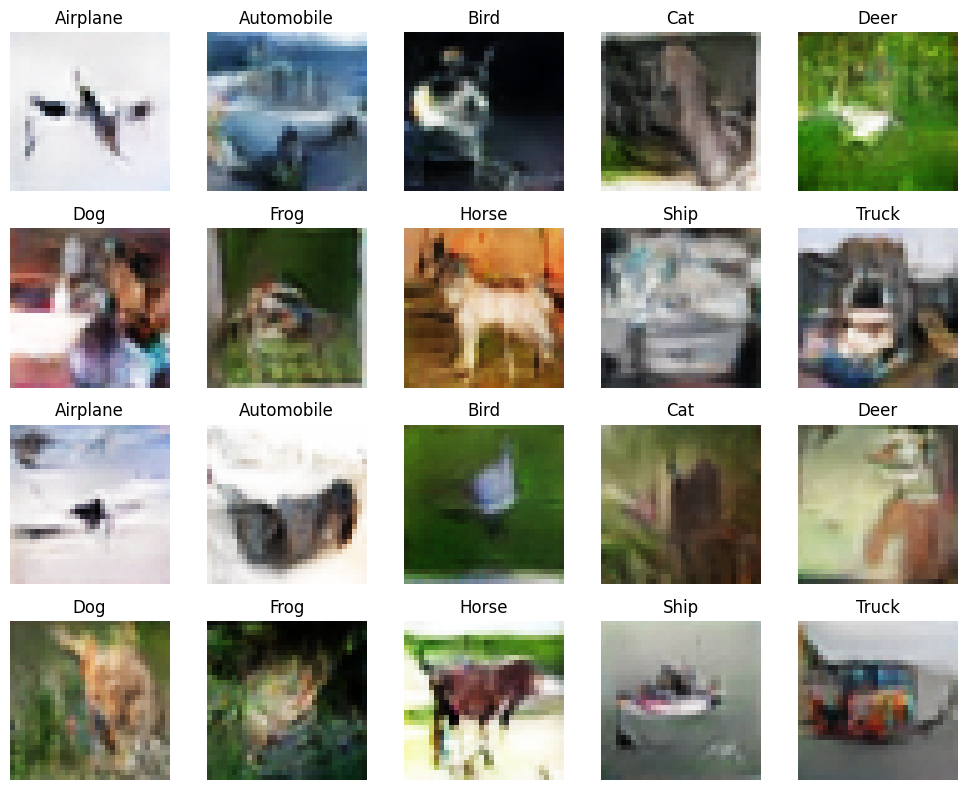

Generator Checkpoint - generator-epoch-80.h5
Epoch 81/100
782/782 [==============================] - 52s 66ms/step - d_loss: 0.0747 - g_loss: 8.4286 - D(x|y): 0.5003 - D(G(z|y)): 0.0390 - KL Divergence: 4.5728
Epoch 82/100
782/782 [==============================] - 52s 67ms/step - d_loss: 0.0673 - g_loss: 8.4602 - D(x|y): 0.5002 - D(G(z|y)): 0.0366 - KL Divergence: 4.5375
Epoch 83/100
782/782 [==============================] - 52s 67ms/step - d_loss: 0.0735 - g_loss: 8.4621 - D(x|y): 0.4999 - D(G(z|y)): 0.0406 - KL Divergence: 4.4775
Epoch 84/100
782/782 [==============================] - 51s 65ms/step - d_loss: 0.0671 - g_loss: 8.5795 - D(x|y): 0.5004 - D(G(z|y)): 0.0350 - KL Divergence: 4.6836
Epoch 85/100
1/1 [==============================] - 0s 154ms/step


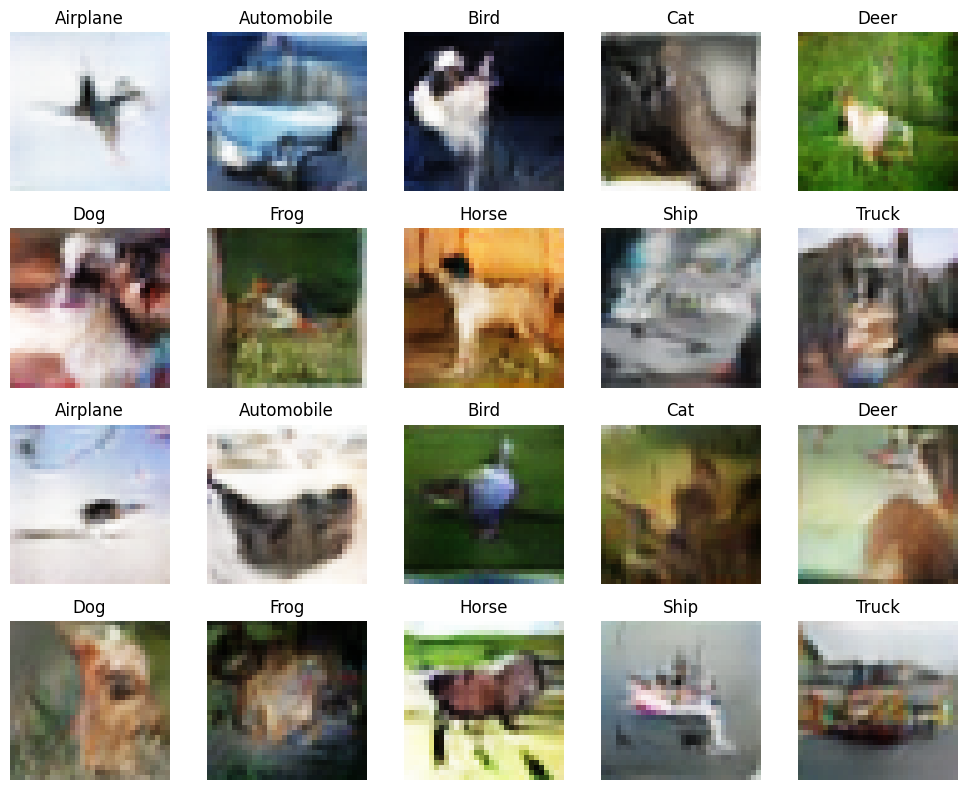

Generator Checkpoint - generator-epoch-85.h5
Epoch 86/100
782/782 [==============================] - 52s 67ms/step - d_loss: 0.0651 - g_loss: 8.7176 - D(x|y): 0.5002 - D(G(z|y)): 0.0360 - KL Divergence: 4.5929
Epoch 87/100
782/782 [==============================] - 52s 66ms/step - d_loss: 0.0678 - g_loss: 8.7411 - D(x|y): 0.5005 - D(G(z|y)): 0.0354 - KL Divergence: 4.5710
Epoch 88/100
782/782 [==============================] - 53s 68ms/step - d_loss: 0.0662 - g_loss: 8.7944 - D(x|y): 0.5000 - D(G(z|y)): 0.0364 - KL Divergence: 4.5543
Epoch 89/100
782/782 [==============================] - 52s 66ms/step - d_loss: 0.0657 - g_loss: 8.7940 - D(x|y): 0.5004 - D(G(z|y)): 0.0354 - KL Divergence: 4.3843
Epoch 90/100
1/1 [==============================] - 0s 47ms/step


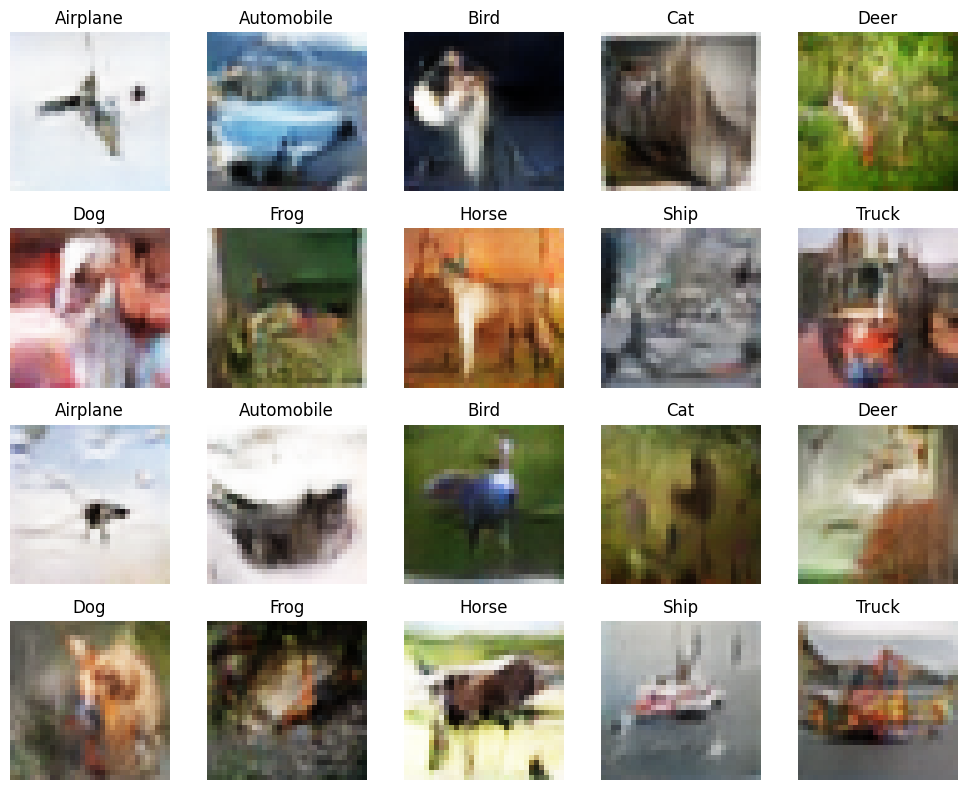

Generator Checkpoint - generator-epoch-90.h5
Epoch 91/100
782/782 [==============================] - 52s 67ms/step - d_loss: 0.0660 - g_loss: 8.9972 - D(x|y): 0.5002 - D(G(z|y)): 0.0341 - KL Divergence: 4.3220
Epoch 92/100
782/782 [==============================] - 54s 69ms/step - d_loss: 0.0657 - g_loss: 8.9568 - D(x|y): 0.5000 - D(G(z|y)): 0.0321 - KL Divergence: 4.4144
Epoch 93/100
782/782 [==============================] - 52s 67ms/step - d_loss: 0.0652 - g_loss: 8.8693 - D(x|y): 0.5002 - D(G(z|y)): 0.0346 - KL Divergence: 4.5018
Epoch 94/100
782/782 [==============================] - 52s 67ms/step - d_loss: 0.0619 - g_loss: 9.0997 - D(x|y): 0.5005 - D(G(z|y)): 0.0333 - KL Divergence: 4.5881
Epoch 95/100
1/1 [==============================] - 0s 46ms/step


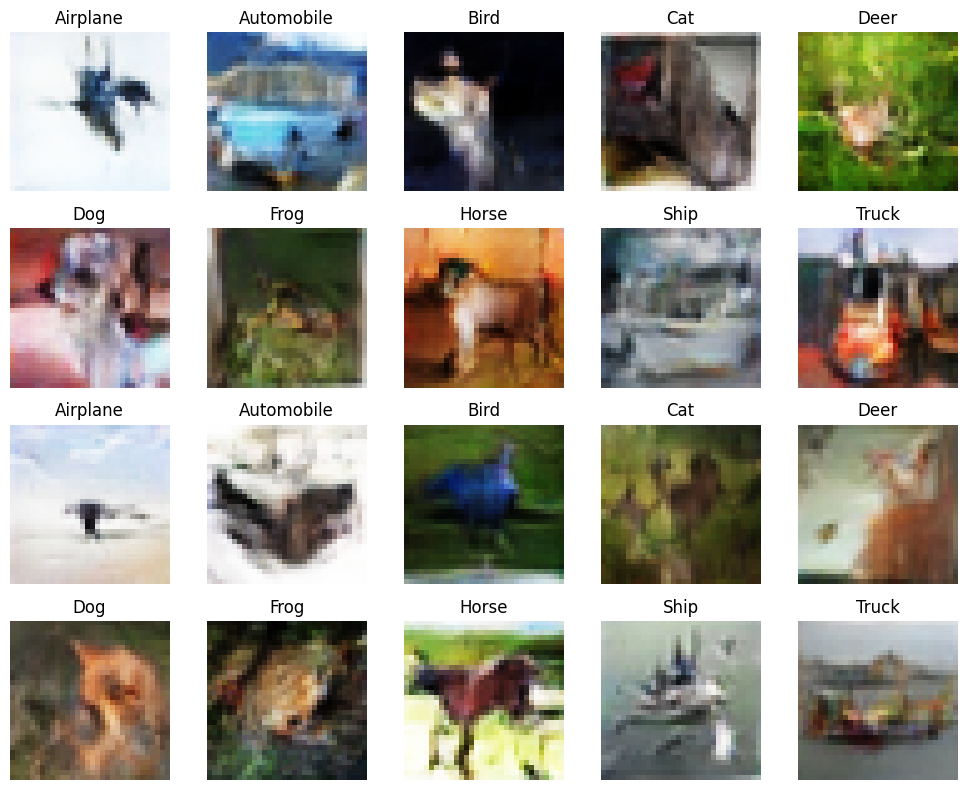

Generator Checkpoint - generator-epoch-95.h5
Epoch 96/100
782/782 [==============================] - 49s 62ms/step - d_loss: 0.0575 - g_loss: 9.2423 - D(x|y): 0.5004 - D(G(z|y)): 0.0309 - KL Divergence: 4.4995
Epoch 97/100
782/782 [==============================] - 53s 68ms/step - d_loss: 0.0584 - g_loss: 9.1515 - D(x|y): 0.5000 - D(G(z|y)): 0.0324 - KL Divergence: 4.5543
Epoch 98/100
782/782 [==============================] - 52s 67ms/step - d_loss: 0.0643 - g_loss: 9.0567 - D(x|y): 0.5001 - D(G(z|y)): 0.0345 - KL Divergence: 4.4659
Epoch 99/100
782/782 [==============================] - 53s 68ms/step - d_loss: 0.0603 - g_loss: 9.2452 - D(x|y): 0.5002 - D(G(z|y)): 0.0311 - KL Divergence: 4.5299
Epoch 100/100
1/1 [==============================] - 0s 48ms/step


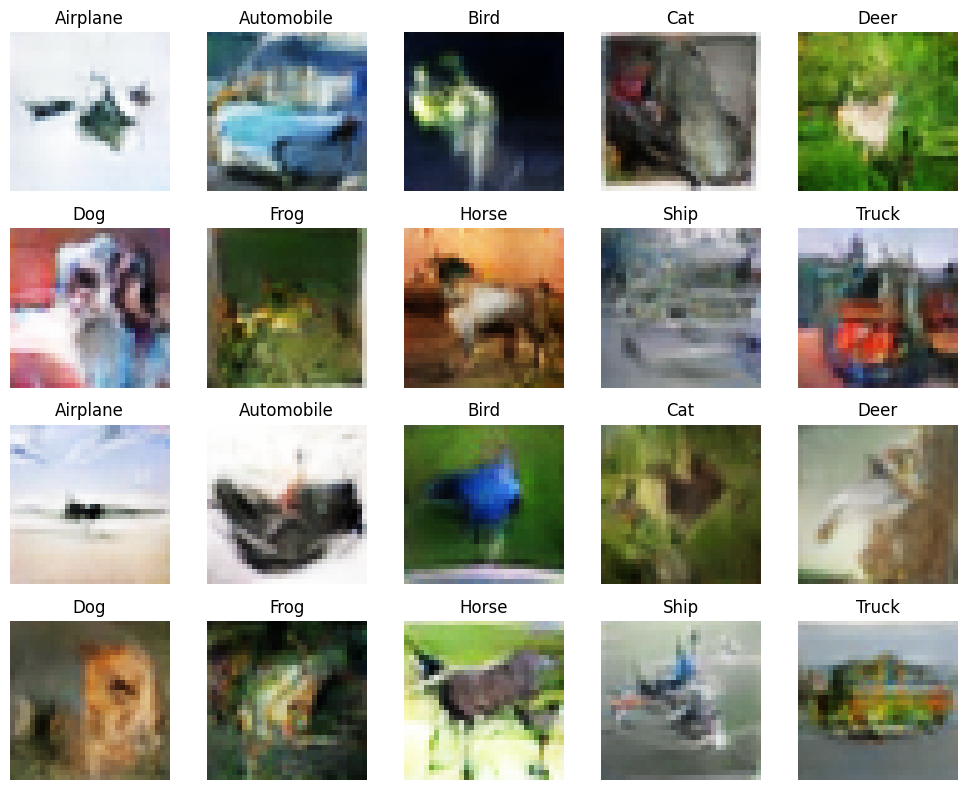

Generator Checkpoint - generator-epoch-Full Train.h5


In [71]:

# Preparing the Dataset with `tf.data`
batch_size = 64
dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
dataset = dataset.shuffle(buffer_size=1024).batch(batch_size, num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)

# Starting the Train Process
hist = cond_gan.fit(dataset, epochs=100, use_multiprocessing=True, workers=16, callbacks=callbacks)

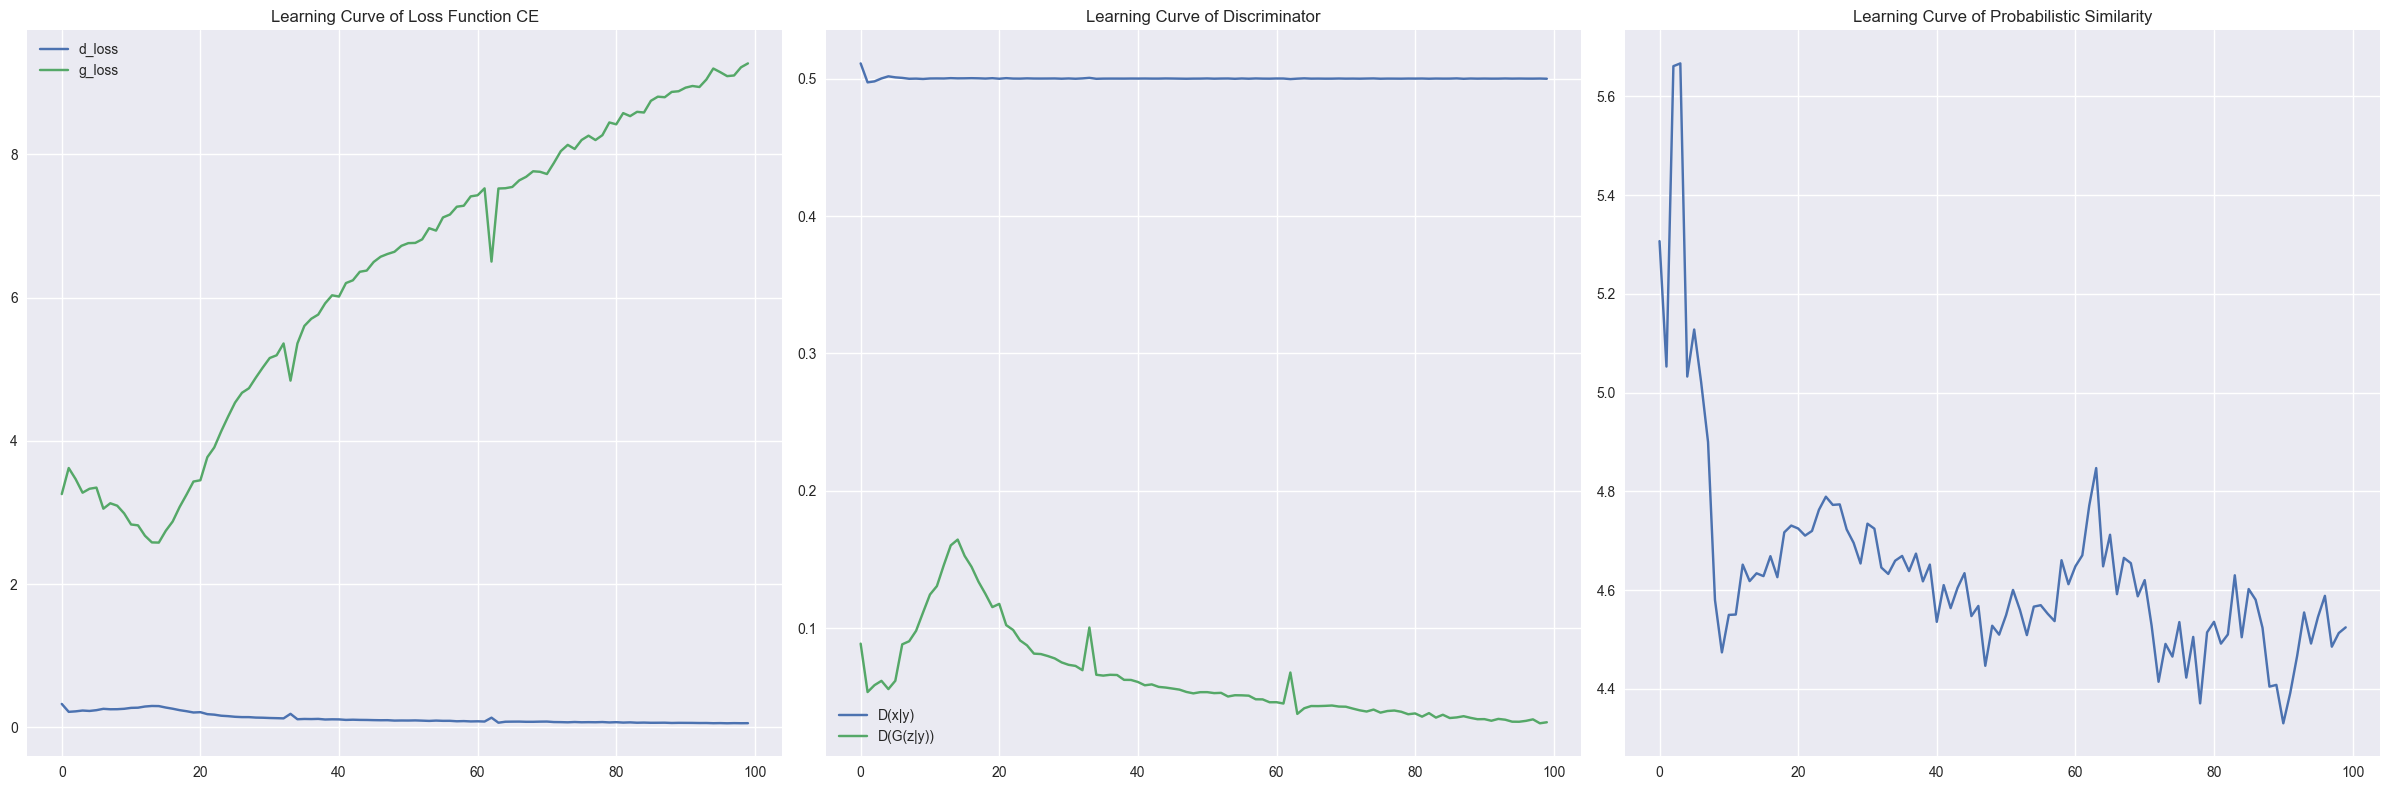

In [72]:
# story history object into dataframe
hist_df = pd.DataFrame(hist.history)

# using pandas dataframe to plot out learning curve
with plt.style.context('seaborn'):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 8), tight_layout=True)
    hist_df.loc[:, ["d_loss", 'g_loss']].plot(ax=ax1, title=r'Learning Curve of Loss Function CE')
    hist_df.loc[:, ['D(x|y)', 'D(G(z|y))']].plot(ax=ax2, title=r'Learning Curve of Discriminator')
    hist_df.loc[:,'KL Divergence'].plot(ax=ax3, title=r'Learning Curve of Probabilistic Similarity')
    plt.show()

In [3]:
# Loading Weights for best Generator
saved_weights = 'generator-epoch-Full Train.h5'
cond_gan.generator.load_weights(saved_weights)
cond_gan.generator.summary()

NameError: name 'cond_gan' is not defined

In [ ]:
n = 1024

# generating labels
labels = np.random.randint(low=0, high=10, size=n)
one_hot_labels = to_categorical(labels)

# Generating 1000 Synthetic Images
random_noise = tf.random.normal(shape=(n, latent_dim))

synthetic_images = cond_gan.generator.predict([random_noise, one_hot_labels])
print("Latent Vector Dim: {}\tGenerated Images Dim: {}".format(random_noise.shape, synthetic_images.shape))

# Scaling back to [0, 1]
synthetic_images -= -1
synthetic_images /= (1 - (-1))

# Display 25 randomly sampled images
fig = plt.figure(figsize=(10, 10), tight_layout=True)
for i in range(25):
    rand_idx = np.random.randint(0, len(synthetic_images))
    ax = fig.add_subplot(5, 5, i+1)
    ax.imshow(synthetic_images[rand_idx])
    ax.set_title(classes[labels[rand_idx]])
    ax.axis('off')
plt.show()

## Evaluation using Fréchet Inception Distance (FID)

In [18]:
import numpy as np
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from scipy.linalg import sqrtm
import math
from tqdm.notebook import tqdm
import tensorflow as tf
from tensorflow.image import resize
class GAN_FID:
    def __init__(self, batch_size, latent_dim, sample_size, buffer_size):
        # setting Hyperparameters
        self.BATCH_SIZE = batch_size
        self.LATENT_DIM = latent_dim
        self.SAMPLE_SIZE = sample_size
        self.BUFFER_SIZE = buffer_size

        # setting Constants
        self.INCEPTION_SHAPE = (299, 299, 3)
        self.INCEPTION = InceptionV3(include_top=False, pooling='avg', input_shape=self.INCEPTION_SHAPE)
        self.AUTO = tf.data.AUTOTUNE

    # method to set generator and training data
    def fit(self, generator, train_data):
        # setting generative model and original data used for training 
        self.GENERATOR = generator
        self.train_data = train_data

        # Preparing Real Images
        trainloader = tf.data.Dataset.from_tensor_slices((self.train_data))
        trainloader = (
            trainloader
            .shuffle(self.BUFFER_SIZE)
            .map(self.__resize_and_preprocess, num_parallel_calls=self.AUTO)
            .batch(self.BATCH_SIZE, num_parallel_calls=self.AUTO)
            .prefetch(self.AUTO)
        )
        self.trainloader = trainloader

        # Generate and prepare Synthetic Images (Fake)
        rand_labels = np.random.randint(low=0, high=10, size=self.SAMPLE_SIZE)
        rand_labels = to_categorical(rand_labels)
        noise = tf.random.normal([self.SAMPLE_SIZE, self.LATENT_DIM])

        generated_images = self.GENERATOR([noise, rand_labels])
        genloader = tf.data.Dataset.from_tensor_slices(generated_images)
        genloader = (
            genloader
            .map(self.__resize_and_preprocess, num_parallel_calls=self.AUTO)
            .batch(self.BATCH_SIZE, num_parallel_calls=self.AUTO)
            .prefetch(self.AUTO)
        )
        self.genloader = genloader

        # prepare embeddings
        count = math.ceil(self.SAMPLE_SIZE/self.BATCH_SIZE)

        ## compute embeddings for real images
        print("Computing Real Image Embeddings")
        self.real_image_embeddings = self.__compute_embeddings(self.trainloader, count)

        ## compute embeddings for generated images
        print("Computing Generated Image Embeddings")
        self.generated_image_embeddings = self.__compute_embeddings(self.genloader, count)
        assert self.real_image_embeddings.shape == self.generated_image_embeddings.shape, "Embeddings are not of the same size"
        print("Computed Embeddings\tReal Images Embedding Shape: {}\tGenerated Images Embedding Shape".format(
            self.real_image_embeddings.shape, 
            self.generated_image_embeddings.shape
        ))
    
    # method to produce evaluation results
    @tf.autograph.experimental.do_not_convert
    def evaluate(self):
        # calculate Frechet Inception Distance
        fid = self.__calculate_fid(self.real_image_embeddings, self.generated_image_embeddings)
        print('The computed FID score is:', fid)

        return fid

    # method to generate embeddings from inception model 
    def __compute_embeddings(self, dataloader, count):
        image_embeddings = []
        for _ in tqdm(range(count)):
            images = next(iter(dataloader))
            embeddings = self.INCEPTION.predict(images)
            image_embeddings.extend(embeddings)
        return np.array(image_embeddings)

    ## STATIC METHODS: these methods knows nothing about the class
    # static method to prepare the data before computing Inception Embeddings
    @staticmethod
    def __resize_and_preprocess(image):
        # image *= 255.0 # original image are scaled to [0, 1], scaling back to [0, 255]
        image -= -1
        image /= (1 - (-1))
        image *= 255.

        # .preprocess_input() expects an image of scale [0, 255]
        image = preprocess_input(image)
        # inception model expects an image of shape (None, 299, 299, 3)
        image = tf.image.resize(image, (299, 299), method='nearest')
        return image

    # static method to calculate frechet inception distance based on embeddings
    @staticmethod 
    def __calculate_fid(real_embeddings, generated_embeddings):
        # calculate mean and covariance statistics
        mu1, sigma1 = real_embeddings.mean(axis=0), np.cov(real_embeddings, rowvar=False)
        mu2, sigma2 = generated_embeddings.mean(axis=0), np.cov(generated_embeddings, rowvar=False)
        # calculate sum squared difference between means
        ssdiff = np.sum((mu1 - mu2)**2.0)
        # calculate sqrt of product between cov
        covmean = sqrtm(sigma1.dot(sigma2))
        # check and correct imaginary numbers from sqrt
        if np.iscomplexobj(covmean):
            covmean = covmean.real
        # calculate score
        fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
        return fid

In [19]:
fid_class = GAN_FID(batch_size=512, latent_dim=128, sample_size=10000, buffer_size=1024)
fid_class.fit(generator=cond_gan.generator, train_data=x_train)
fid_score = fid_class.evaluate()


Computing Real Image Embeddings


ImportError: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html

# Trying out DCGAN
>DCGAN is a Deep Convolutional Generative Adversarial network that uses Deep Conv Nets to have a stable architecture and better results. The Generator in GAN uses a fully connected network, whereas DCGAN uses a Transposed Convolutional network to upsample the images.

In [20]:
def define_discriminator(in_shape=(32,32,3)):
    model = Sequential()
    model.add(Conv2D(64, (3,3), padding='same', input_shape=in_shape))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(256, (3,3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

In [21]:
def define_generator(latent_dim):
    model = Sequential()
    n_nodes = 256 * 4 * 4
    model.add(Dense(n_nodes, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((4, 4, 256)))
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(3, (3,3), activation='tanh', padding='same'))
    return model

In [22]:
def define_gan(g_model, d_model):
    d_model.trainable = False
    model = Sequential()
    model.add(g_model)
    model.add(d_model)
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

In [23]:
def load_real_samples():
    (trainX, _), (_, _) = load_data()
    X = trainX.astype('float32')
    X = (X - 127.5) / 127.5
    return X
def generate_real_samples(dataset, n_samples):
    ix = randint(0, dataset.shape[0], n_samples)
    X = dataset[ix]
    y = ones((n_samples, 1))
    return X, y
 
def generate_latent_points(latent_dim, n_samples):
    x_input = randn(latent_dim * n_samples)
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input
 
def generate_fake_samples(g_model, latent_dim, n_samples):
    x_input = generate_latent_points(latent_dim, n_samples)
    X = g_model.predict(x_input)
    y = zeros((n_samples, 1))
    return X, y

In [24]:
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=1000, n_batch=128):
    bat_per_epo = int(dataset.shape[0] / n_batch)
    half_batch = int(n_batch / 2)
    for i in range(n_epochs):
        for j in range(bat_per_epo):
            X_real, y_real = generate_real_samples(dataset, half_batch)
            d_loss1, _ = d_model.train_on_batch(X_real, y_real)
            X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            d_loss2, _ = d_model.train_on_batch(X_fake, y_fake)
            X_gan = generate_latent_points(latent_dim, n_batch)
            y_gan = ones((n_batch, 1))
            g_loss = gan_model.train_on_batch(X_gan, y_gan)
            print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' %
                (i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))

        #print images for every 10th epoch
        if (i+1) % 10 == 0:
            summarize_performance(i, g_model, latent_dim)
            
def save_plot(examples, epoch, n=10):
    for i in range(n * n):
        plt.subplot(n, n, 1 + i)
        plt.axis('off')
        plt.imshow(examples[i, :, :, 0], cmap='gray_r')
    filename = 'generated_plot_e%03d.png' % (epoch+1)
    plt.savefig(filename)
    plt.close()            



In [25]:
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=150):
    X_real, y_real = generate_real_samples(dataset, n_samples)
    _, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
    x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
    _, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
    print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
    save_plot(x_fake, epoch)
    filename = 'generator_model_%03d.h5' % (epoch+1)
    g_model.save(filename)

In [26]:
latent_dim = 100
d_model = define_discriminator()
g_model = define_generator(latent_dim)
gan_model = define_gan(g_model, d_model)
dataset = load_real_samples()
hist = train(g_model, d_model, gan_model, dataset, latent_dim)


c:\Users\Xavier\anaconda3\envs\gpu_env\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


AttributeError: 'Sequential' object has no attribute 'generator'

In [ ]:
# story history object into dataframe
hist_df = pd.DataFrame(hist.history)

# using pandas dataframe to plot out learning curve
with plt.style.context('seaborn'):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 8), tight_layout=True)
    hist_df.loc[:, ["d_loss", 'g_loss']].plot(ax=ax1, title=r'Learning Curve of Loss Function CE')
    hist_df.loc[:, ['D(x|y)', 'D(G(z|y))']].plot(ax=ax2, title=r'Learning Curve of Discriminator')
    hist_df.loc[:,'KL Divergence'].plot(ax=ax3, title=r'Learning Curve of Probabilistic Similarity')
    plt.show()

NameError: name 'hist' is not defined

In [ ]:
# using pandas dataframe to plot out learning curve
with plt.style.context('seaborn'):
    for cols in [["d_loss", "g_loss"], ["D(x|y)", "D(G(z|y))"], "KL Divergence"]:
        fig, ax = plt.subplots(1, 1, figsize=(8, 8), tight_layout=True)
        hist_df.loc[:, cols].plot(ax=ax)
        plt.show()

In [ ]:
n = 1024

# generating labels
labels = np.random.randint(low=0, high=10, size=n)
one_hot_labels = to_categorical(labels)

# Generating 1000 Synthetic Images
random_noise = tf.random.normal(shape=(n, latent_dim))

synthetic_images = cond_gan.generator.predict([random_noise, one_hot_labels])
print("Latent Vector Dim: {}\tGenerated Images Dim: {}".format(random_noise.shape, synthetic_images.shape))

# Scaling back to [0, 1]
synthetic_images -= -1
synthetic_images /= (1 - (-1))

# Display 25 randomly sampled images
fig = plt.figure(figsize=(10, 10), tight_layout=True)
for i in range(25):
    rand_idx = np.random.randint(0, len(synthetic_images))
    ax = fig.add_subplot(5, 5, i+1)
    ax.imshow(synthetic_images[rand_idx])
    ax.set_title(classes[labels[rand_idx]])
    ax.axis('off')
plt.show()

# Trying out ACGAN
Auxiliary Classifier Generative Adversarial Network

## Generator Built

## Discriminator Built

## Combining Generator and Discriminator

# Trying out with upsampling and BatchNorm


In [ ]:
def build_generator():

        model = Sequential()

        model.add(Dense(128 * 8 * 8, activation="relu", input_dim=latent_dim))
        model.add(Reshape((8, 8, 128)))
        
        model.add(UpSampling2D())#upsamples to 16*16*128
        
        model.add(Conv2D(128, kernel_size=3, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        
        model.add(UpSampling2D()) #upsamples to 32*32*128
        
        model.add(Conv2D(64, kernel_size=3, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        
        model.add(Conv2D(3, kernel_size=3, padding="same"))
        model.add(Activation("tanh"))

        #outputs an image of 32*32*3

        noise = Input(shape=(latent_dim,))
        img = model(noise)
        model.summary()
        return Model(noise, img)

In [ ]:
def build_discriminator():
        model = Sequential()

        model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=img_shape, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        #no normalization for the first layer 
        
        model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
        model.add(ZeroPadding2D(padding=((0,1),(0,1))))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        
        model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        
        model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        
        model.add(Flatten())
        model.add(Dense(1, activation='sigmoid'))

        

        img = Input(shape=img_shape)
        validity = model(img)
        model.summary()
        return Model(img, validity)

In [ ]:
discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy',
            optimizer=Adam(0.0002,0.5),
            metrics=['accuracy'])

# Build the generator
generator = build_generator()

# The generator takes noise as input and generates imgs
z = Input(shape=(latent_dim,))
img = generator(z)

# For the combined model we will only train the generator
discriminator.trainable = False

# The discriminator takes generated images as input and determines validity
valid = discriminator(img)

# The combined model  (stacked generator and discriminator)
# Trains the generator to fool the discriminator
combined = Model(z, valid)
combined.compile(loss='binary_crossentropy', optimizer=Adam(0.0002,0.5))

Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_117 (Conv2D)         (None, 16, 16, 32)        896       
                                                                 
 leaky_re_lu_123 (LeakyReLU)  (None, 16, 16, 32)       0         
                                                                 
 dropout_111 (Dropout)       (None, 16, 16, 32)        0         
                                                                 
 conv2d_118 (Conv2D)         (None, 8, 8, 64)          18496     
                                                                 
 zero_padding2d (ZeroPadding  (None, 9, 9, 64)         0         
 2D)                                                             
                                                                 
 batch_normalization_94 (Bat  (None, 9, 9, 64)         256       
 chNormalization)                                    

>mode collapsed occured

# Trying out with SAGAN

# Trying out with WGAN